# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

# Run DASK dist client 

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41075,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.04 GiB
Comm: tcp://127.0.0.1:43711,Total threads: 4
Dashboard: http://127.0.0.1:42583/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:42169,


In [3]:
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

# Read and merge

In [4]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022, 2023],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [5]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 84.8 ms, sys: 7.76 ms, total: 92.6 ms
Wall time: 87.9 ms


In [6]:
%%time

index=0
before = get_ddf_shape(bbdd_completa)
print(before)

index+=1
print(index)
# 1 Error fix. # 2019 gener, febrer and marc have the status reversed
cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))
index+=1
print(index)
# 2 Remove not needed status, manitenance, planned. open = 0, closed = 1 
cond = (bbdd_completa['status'].isin([2.0,3.0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, 1.0)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])
index+=1
print(index)
# 3 Remove data from 2020
cond = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])
index+=1
print(index)
# 4 2019 to 2020 to have continuos data 
cond = (bbdd_completa['year'].isin([2019]))
bbdd_completa['year'] = bbdd_completa['year'].mask(cond, bbdd_completa['year']+1)
index+=1
print(index)
# 5 status reversed 
bbdd_completa['status'] = (bbdd_completa['status'] + 1)%2
index+=1
print(index)
# 6 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_installed'])
index+=1
print(index)
# 7 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])
index+=1
print(index)
# 8 Remove row where status = closed and is renting and is returning
# cond = (bbdd_completa['status'].isin([0.0])) & (bbdd_completa['is_renting'].isin([1.0])) & (bbdd_completa['is_returning'].isin([1.0]))
# bbdd_completa = bbdd_completa.mask(cond, np.nan)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')
# 14138178

(14138683, 23)
1
2
3
4
5
6
7
8
(14138178, 21)
Changes to dataframe durinf preprocessing
dropeed -505 rows
dropped -2 columns
CPU times: user 3.83 s, sys: 0 ns, total: 3.83 s
Wall time: 15.8 s


## General view

In [7]:
bbdd_completa.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_renting', 'is_returning',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [8]:

len(bbdd_completa.divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

42

In [9]:
bbdd_completa.head(2)

,station_id,num_docks_available,num_bikes_available,status,timestamp,is_renting,is_returning,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,year,month,dayofweek,day,dayofyear,hour,capacity,ctx0,ctx1,ctx2,ctx3,ctx4
0,1,8.363636,17.636364,1,1546300800,1,1,17.636364,0.0,2020,1,1,1,1,0,46.0,0.181818,0.181818,0.181818,0.181818,0.181818
1,1,0.818182,26.181818,1,1546380000,1,1,26.181818,0.0,2020,1,1,1,1,22,46.0,0.017787,0.021739,0.023715,0.106719,0.094203


In [10]:
%%time

get_ddf_shape(bbdd_completa)

CPU times: user 2.73 s, sys: 119 ms, total: 2.85 s
Wall time: 9.51 s


(14138178, 21)

In [11]:
%%time

nans = get_features_nans(bbdd_completa)

zeros = get_features_zero(bbdd_completa)

CPU times: user 8.12 s, sys: 565 ms, total: 8.69 s
Wall time: 37.4 s


In [12]:
nans

{}

In [13]:
zeros

{'num_docks_available': 1.0187804963270373,
 'num_bikes_available': 5.990432430543738,
 'status': 3.127927799466098,
 'is_renting': 0.06312694606051784,
 'is_returning': 0.06305621558874136,
 'num_bikes_available_types.mechanical': 16.130621640214176,
 'num_bikes_available_types.ebike': 27.885396548268098,
 'dayofweek': 14.250860330093454,
 'hour': 4.314339513903418,
 'ctx0': 1.0187804963270373,
 'ctx1': 1.0173871060330404,
 'ctx2': 1.0150530004644163,
 'ctx3': 1.0126057261409498,
 'ctx4': 1.0100735752513512}

In [14]:
%%time 

uniques = get_columns_unique(bbdd_completa)

CPU times: user 26.1 s, sys: 1.98 s, total: 28.1 s
Wall time: 2min 53s


In [15]:
uniques

{'station_id': 0        1.0
 1      320.0
 2      319.0
 3      318.0
 4      317.0
        ...  
 508     91.0
 509    467.0
 510     52.0
 511    431.0
 512    520.0
 Name: station_id, Length: 513, dtype: float64,
 'num_docks_available': 0         8.363636
 1         0.818182
 2         0.000000
 3         6.818182
 4         7.909091
            ...    
 12503     1.925926
 12504    10.022222
 12505    22.680000
 12506    34.550000
 12507    45.850000
 Name: num_docks_available, Length: 12508, dtype: float64,
 'num_bikes_available': 0        17.636364
 1        26.181818
 2        27.000000
 3        21.181818
 4        20.181818
            ...    
 10705    11.965517
 10706    13.500000
 10707    21.461538
 10708    24.416667
 10709    31.777778
 Name: num_bikes_available, Length: 10710, dtype: float64,
 'status': 0    1.0
 1    0.0
 Name: status, dtype: float64,
 'timestamp': 0        1.546301e+09
 1        1.546380e+09
 2        1.546402e+09
 3        1.546416e+09
 4        1.54

In [16]:
xticks = np.asanyarray(
    (
        uniques['timestamp'].min(), 
        np.round(uniques['timestamp'].mean()-uniques['timestamp'].std()).astype(int),
        np.round(uniques['timestamp'].mean()).astype(int),
        np.round(uniques['timestamp'].mean()+uniques['timestamp'].std()).astype(int),
        uniques['timestamp'].max()
    )
)
xticks

array([1.54630080e+09, 1.57919369e+09, 1.62230010e+09, 1.66540651e+09,
       1.68557040e+09])

# Genral Station IDs

In [17]:
%%time

print(stats.describe(bbdd_completa.station_id))
bbdd_completa.station_id.describe().compute()

DescribeResult(nobs=14138178, minmax=(1.0, 520.0), mean=250.01320615711586, variance=20993.498962650236, skewness=0.05372247883870138, kurtosis=-1.1227416572692386)
CPU times: user 3.6 s, sys: 597 ms, total: 4.2 s
Wall time: 18 s


count    1.413818e+07
mean     2.500132e+02
std      1.448913e+02
min      1.000000e+00
25%      1.330000e+02
50%      2.640000e+02
75%      3.900000e+02
max      5.200000e+02
Name: station_id, dtype: float64

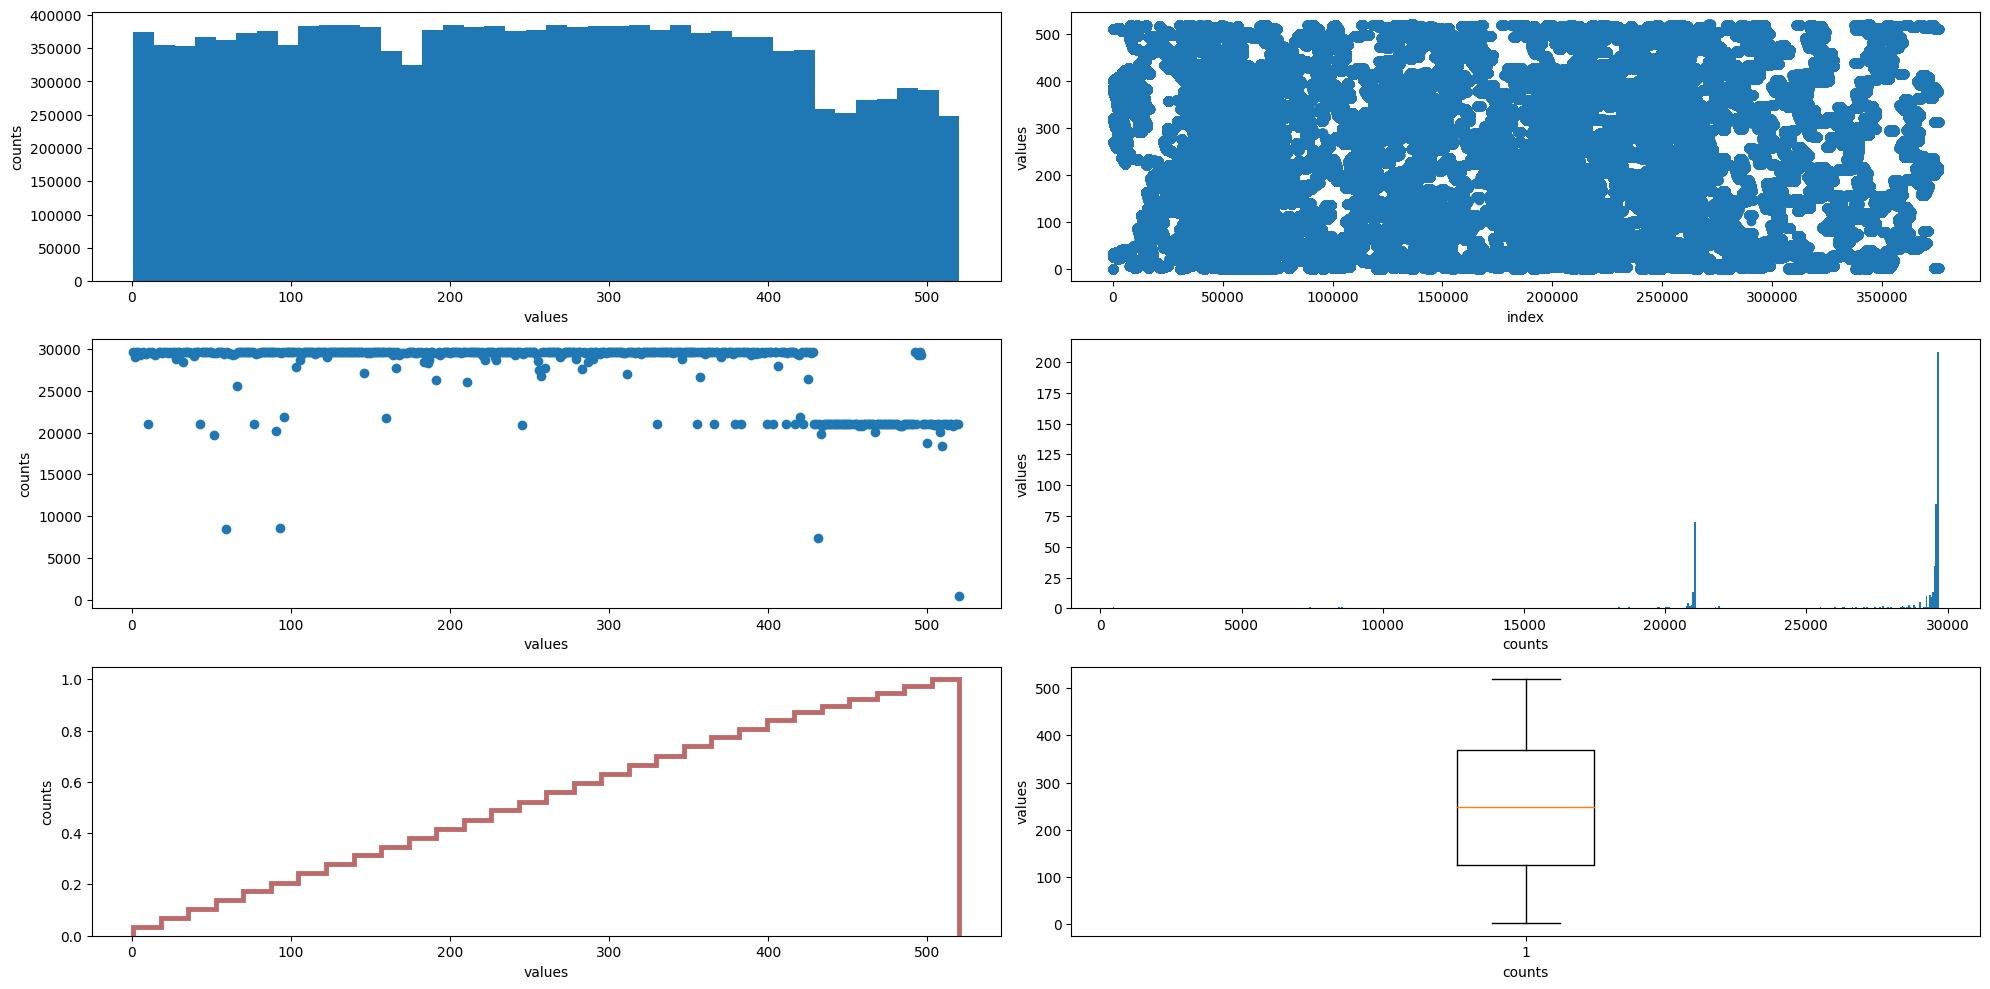

CPU times: user 22 s, sys: 2.05 s, total: 24 s
Wall time: 28.9 s


In [18]:
%%time

show_counts(bbdd_completa.station_id.compute())

## Split estaciones 2019 - 2022

In [19]:
client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

In [20]:
def drop_duplicates_per_year(ddf):
    years = ddf.year.unique()
    
    before = get_ddf_shape(ddf)
    print(before)
    
    data = list()
    
    for year in years:
        print(year)
        data_year = ddf[ddf.year.isin([year])]
        
        data_year = data_year.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')
        
        data.append(data_year)
        
        client.run(trim_memory)
        
        time.sleep(1)
        
    ddf_clean = dd.concat(data, interleave_partitions=False)
    
    after = get_ddf_shape(ddf_clean)
    print(after)

    print('Changes to dataframe durinf preprocessing')
    print(f'dropeed {(after[0]-before[0]):02d} rows')
    print(f'dropped {(after[1]-before[1]):02d} columns')
    return ddf_clean


In [21]:
%%time

bbdd_completa = drop_duplicates_per_year(bbdd_completa)

(14138178, 21)
2020.0
2021.0
2022.0
2023.0
(13992397, 21)
Changes to dataframe durinf preprocessing
dropeed -145781 rows
dropped 00 columns
CPU times: user 8.51 s, sys: 667 ms, total: 9.18 s
Wall time: 36.3 s


In [22]:
%%time

unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2020])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

year
2020.0    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
2023.0    [1, 34, 386, 385, 384, 383, 35, 382, 381, 380,...
Name: station_id, dtype: object
2020.0 (410,)
2021.0 (509,)
2022.0 (510,)
2023.0 (508,)
405
CPU times: user 2.21 s, sys: 179 ms, total: 2.39 s
Wall time: 12.8 s


# IDs estaciones comunes (training data)

In [23]:
%%time

get_ddf_shape(filtered_bbdd)
#bbdd_completa.shape = (12531377, 23)

CPU times: user 3.89 s, sys: 317 ms, total: 4.21 s
Wall time: 16.9 s


(11815577, 21)

value counts stats {'max': 29388, 'mean': 29174.264197530865, 'median': 29333.0, 'std': 522.8866912707567, 'min': 25276}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 15.3 s, sys: 1.29 s, total: 16.5 s
Wall time: 1min 34s


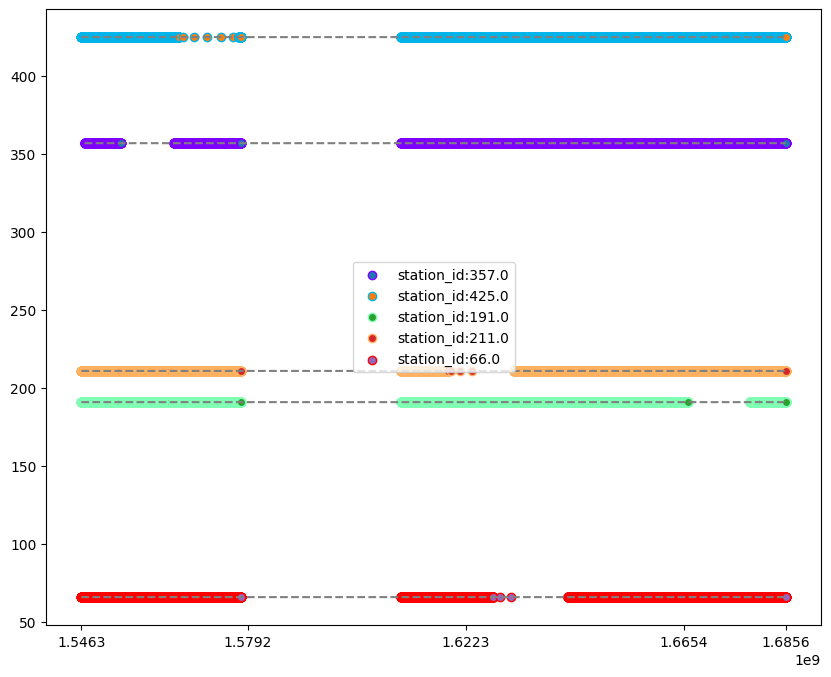

In [24]:
%%time

scatter_columns(
    filtered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

## IDs estaciones no comunes (testing data)

In [25]:
%%time

get_ddf_shape(nonfiltered_bbdd)
#bbdd_completa.shape = (12531377, 23)

CPU times: user 4.19 s, sys: 282 ms, total: 4.47 s
Wall time: 17.5 s


(2176820, 21)

value counts stats {'max': 21716, 'mean': 20155.74074074074, 'median': 20788.0, 'std': 2865.46672282773, 'min': 432}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 15.6 s, sys: 1.29 s, total: 16.9 s
Wall time: 1min 34s


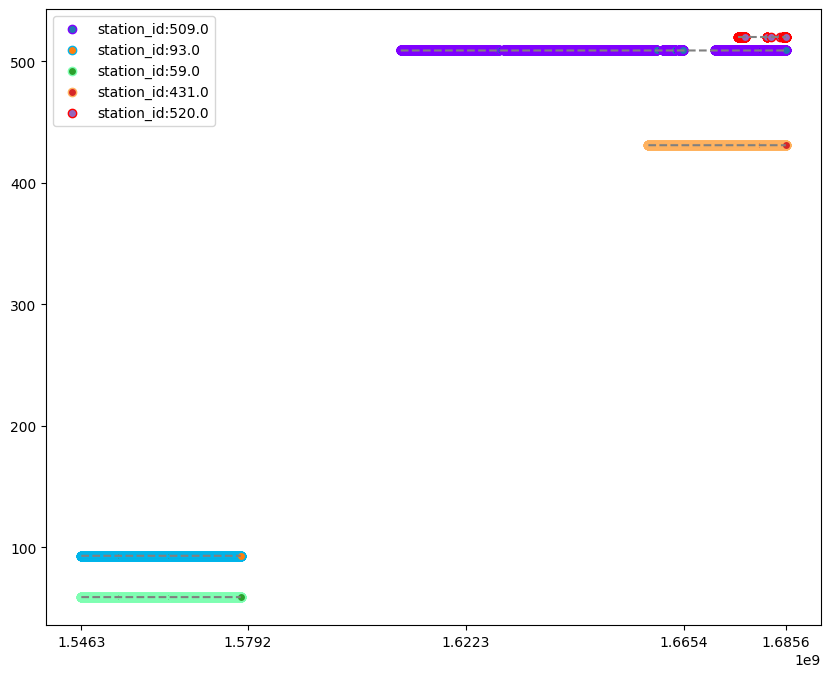

In [26]:
%%time

scatter_columns(
    nonfiltered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

# Data exploration__________________________________

## · Descriptiva
Media, mediana, desviación estándar, mínimo y máximo para columnas numéricas Idea general de la distribución y el rango de los valores en esas columnas.

<div>
    <table>
        <tr>
            <th><p>Camp<p><th>
            <th><p>Descripció<p><th>
        <tr>
        <tr>
            <td><p>last_updated<p><td>
            <td><p>Timestamp de l'arxiu<p><td>
        <tr>
        <tr>
            <td><p>ttl<p><td>
            <td><p>TimeToLive de la resposta<p><td>
        <tr>
        <tr>
            <td><p>data<p><td>
            <td><p>Contenidor d'arrays d'informació d'estacions<p><td>
        <tr>
        <tr>
            <td><p>stations<p><td>
            <td><p>Array de dades de cada estació<p><td>
        <tr>
        <tr>
            <td><p>station_id<p><td>
            <td><p>Identificador de l'estació<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available<p><td>
            <td><p>Nombre de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available_types<p><td>
            <td><p>Array de tipus de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>mechanical<p><td>
            <td><p>Nombre de bicicletes mecàniques disponibles<p><td>
        <tr>
        <tr>
            <td><p>ebike<p><td>
            <td><p>Nombre de bicicletes elèctriques disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_docks_available<p><td>
            <td><p>Nombre de ancoratges disponibles<p><td>
        <tr>
        <tr>
            <td><p>is_installed<p><td>
            <td><p>L'estació està correctament instalada (0-NO,1-SI)<p><td>
        <tr>
        <tr>
            <td><p>is_renting<p><td>
            <td><p>L'estació està proporcionant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>is_returning<p><td>
            <td><p>L'estació està ancorant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>last_reported<p><td>
            <td><p>Timestamp de la informació de l'estació<p><td>
        <tr>
        <tr>
            <td><p>is_charging_station<p><td>
            <td><p>L'estació té capacitat de càrrega de bicicletes elèctriques<p><td>
        <tr>
        <tr>
            <td><p>status<p><td>
            <td><p>
                Estat de l'estació (IN_SERVICE=En servei, CLOSED=Tancada)
                 ['IN_SERVICE', 'OPEN', 'OPN', 'CLS', 'CLOSED', 'NOT_IN_SERVICE', 'MAINTENANCE', 'PLANNED']                     [0, 0, 0, 1, 1, 1,  2, 3]
                <p><td>
        <tr>
    <table>
<div>

### Time columns 

In [27]:
client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

#### 'timestamp'

DescribeResult(nobs=11815577, minmax=(1546300800.0, 1685570400.0), mean=1622506313.4586487, variance=1851155498303136.5, skewness=-0.4086028336742937, kurtosis=-1.1947536646526478)


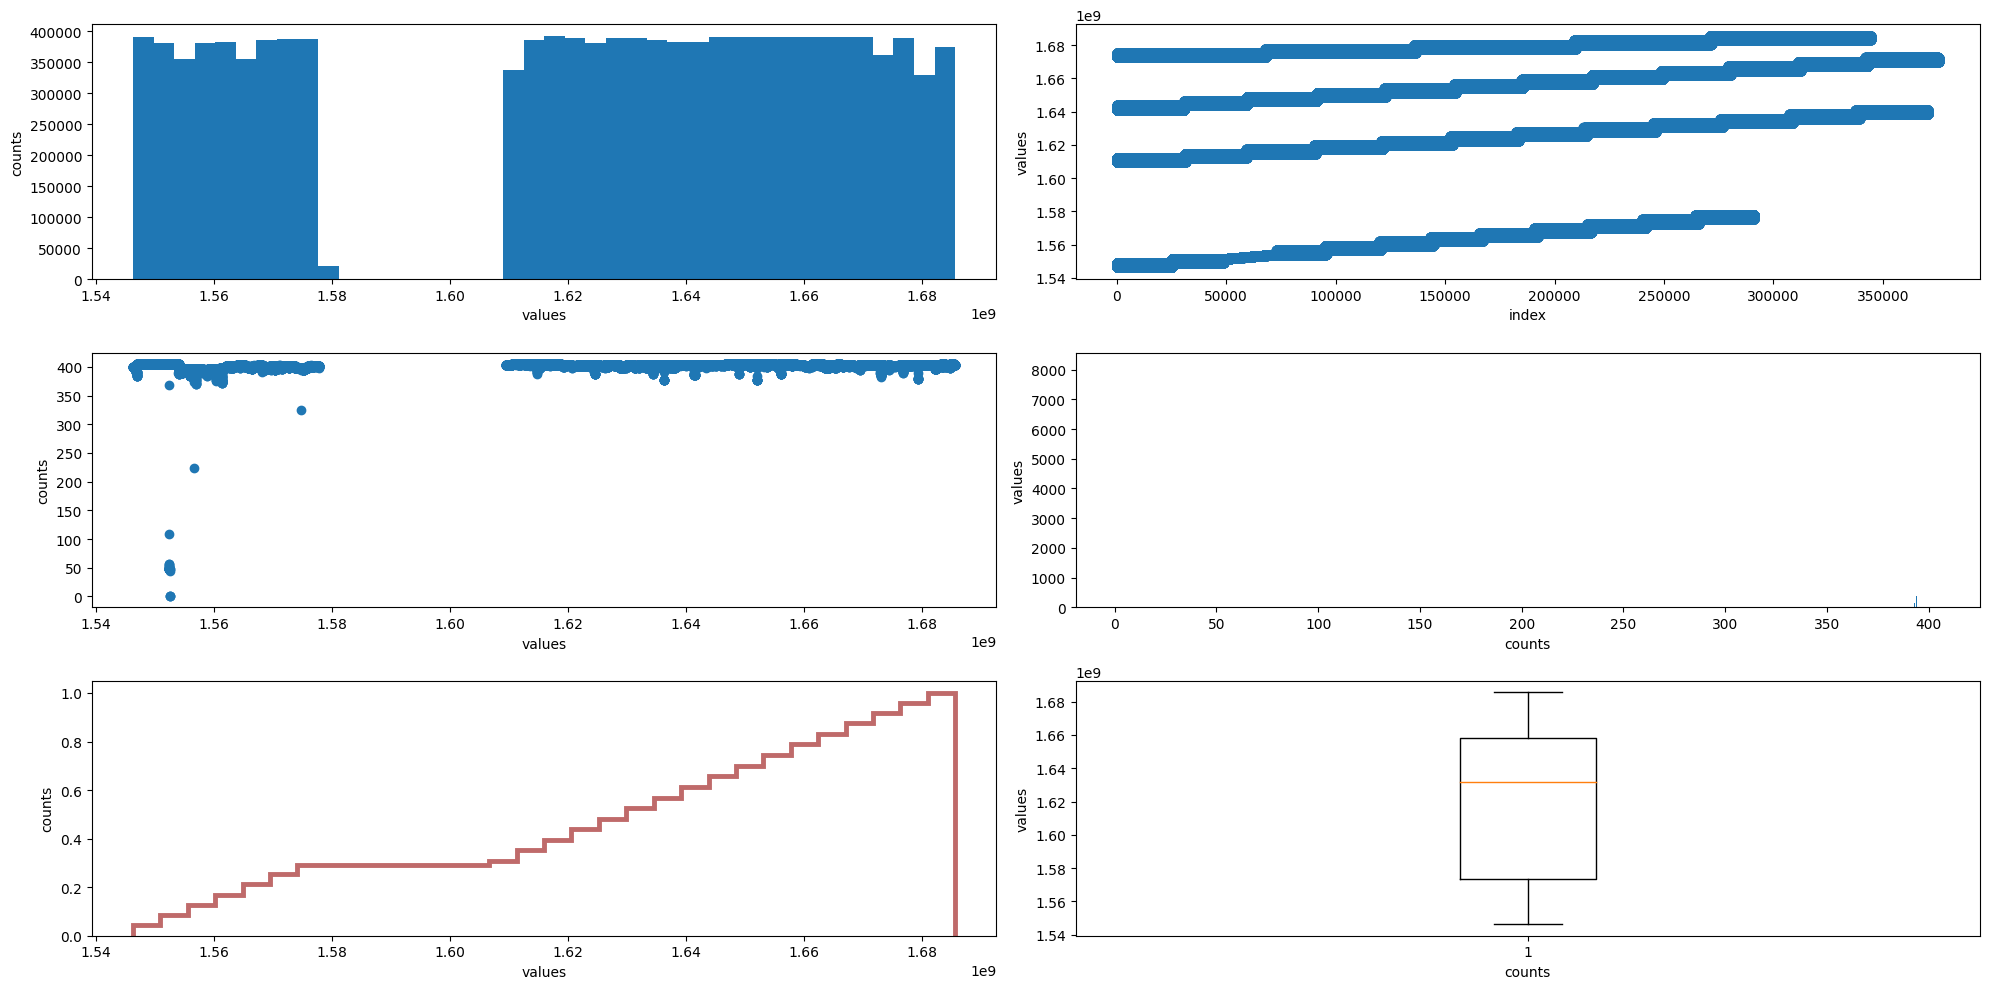

CPU times: user 1min 1s, sys: 6.57 s, total: 1min 7s
Wall time: 1min 27s


In [28]:
%%time
print(stats.describe(filtered_bbdd.timestamp))
filtered_bbdd.timestamp.describe()

show_counts(filtered_bbdd.timestamp.compute())

#### 'year' 

DescribeResult(nobs=11815577, minmax=(2020.0, 2023.0), mean=2021.2378500008929, variance=0.990270877842974, skewness=0.2082593617710562, kurtosis=-1.0755981228510556)


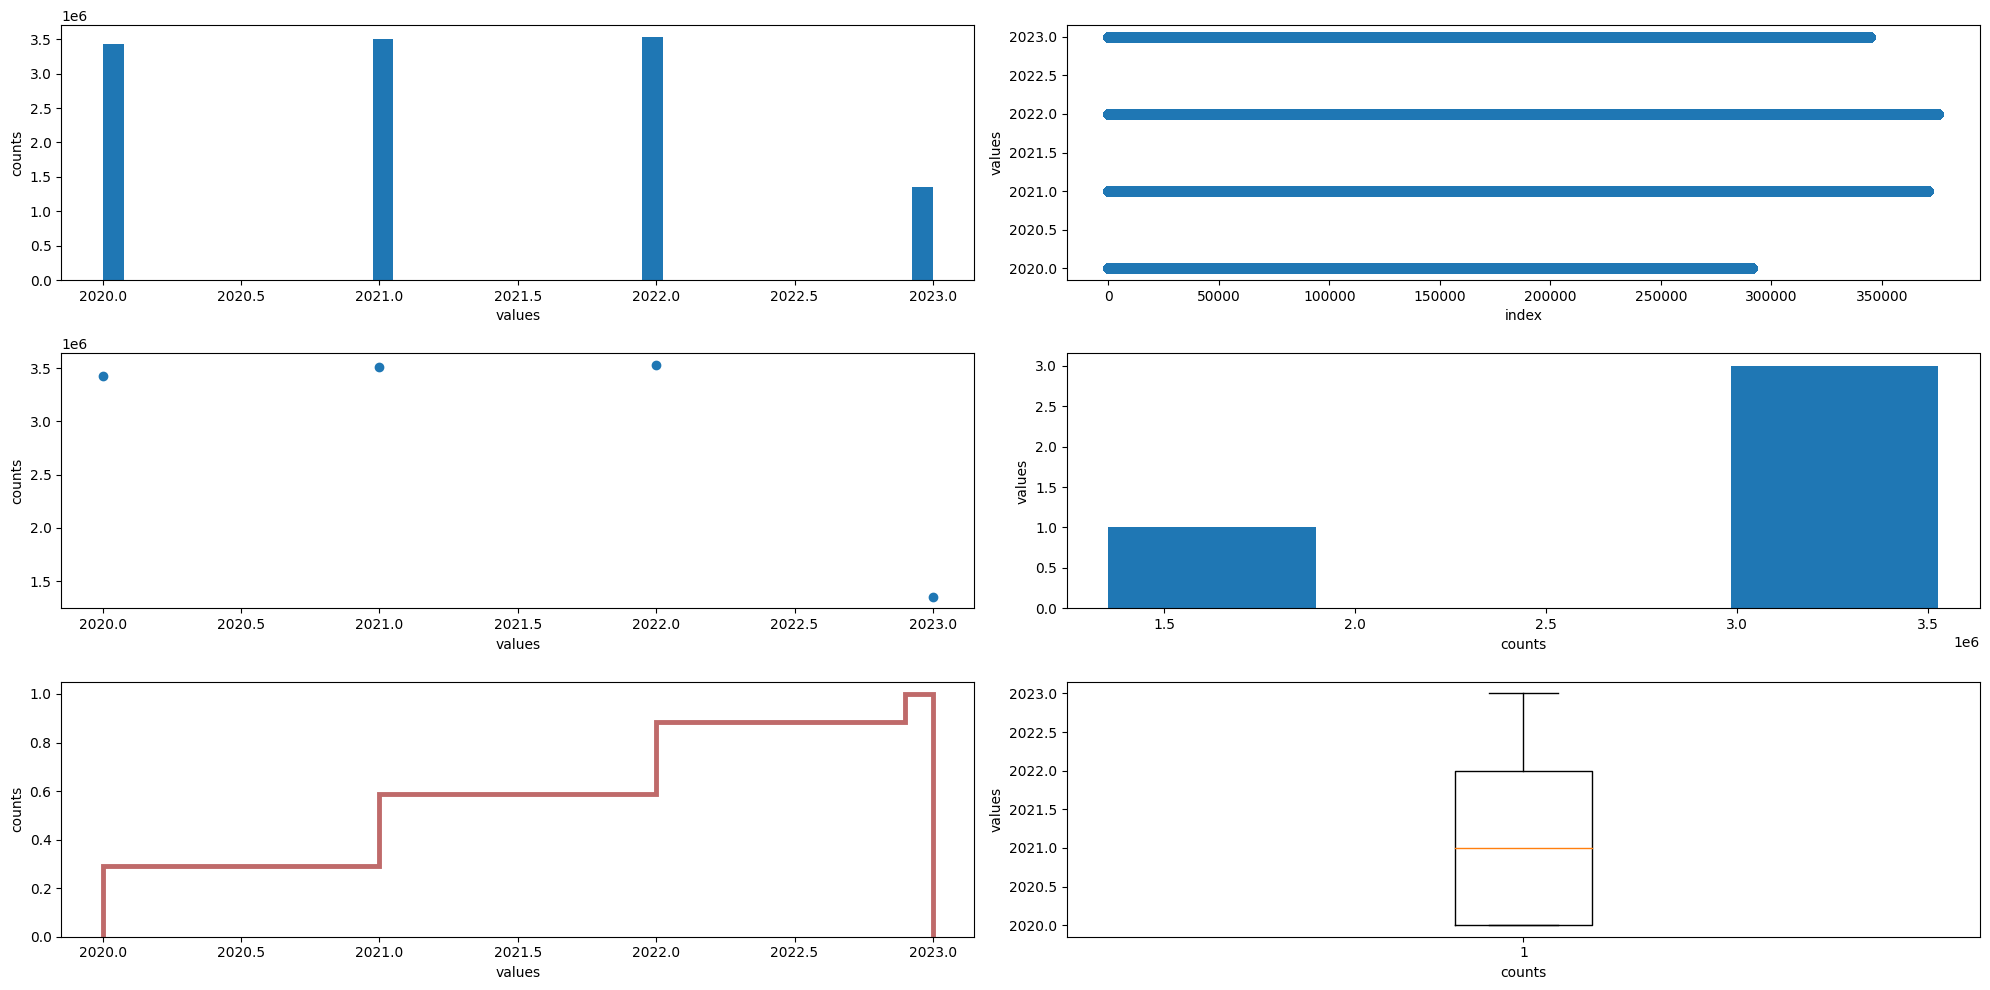

CPU times: user 22.5 s, sys: 1.6 s, total: 24.1 s
Wall time: 49.3 s


In [29]:
%%time
print(stats.describe(filtered_bbdd.year))
filtered_bbdd.year.describe()
show_counts(filtered_bbdd.year.compute())

#### 'month'

DescribeResult(nobs=11815577, minmax=(1.0, 12.0), mean=6.126234546141927, variance=12.068771838330532, skewness=0.15920039124698046, kurtosis=-1.2135251243416825)


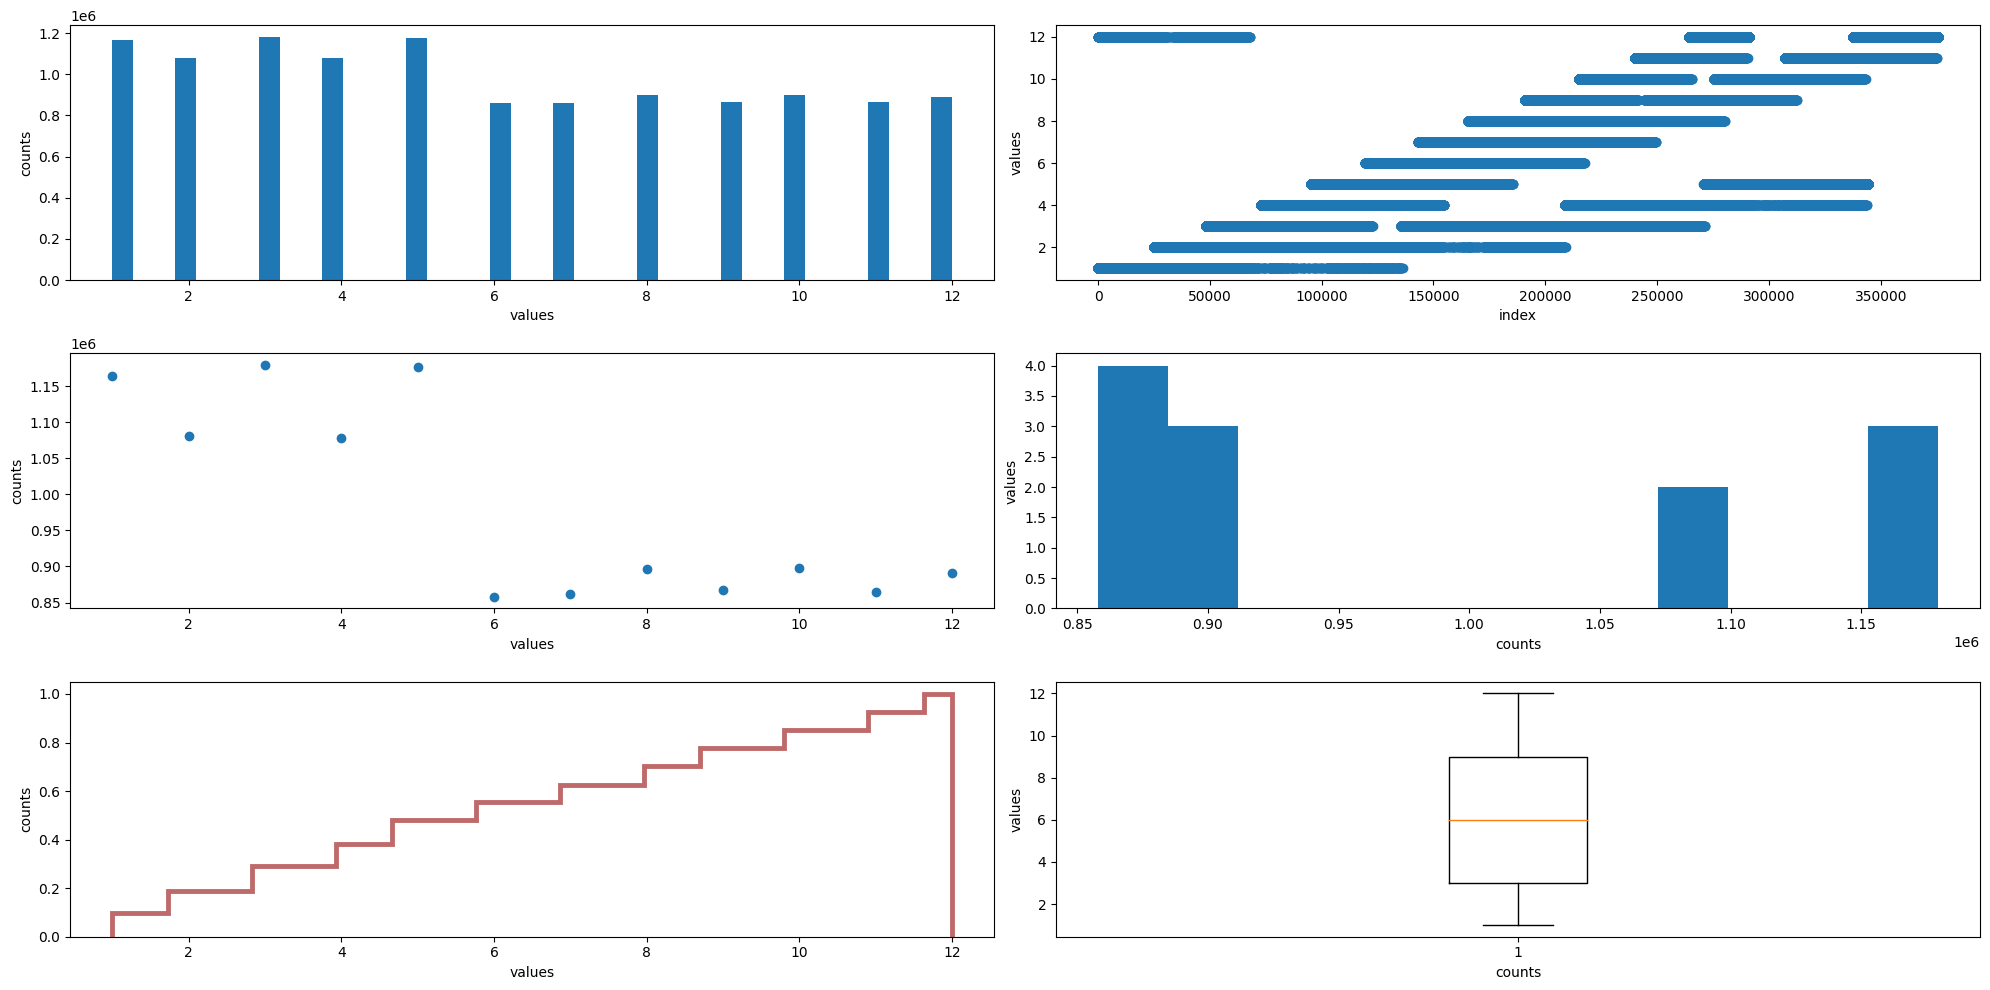

CPU times: user 22.2 s, sys: 1.6 s, total: 23.8 s
Wall time: 49 s


In [30]:
%%time
print(stats.describe(filtered_bbdd.month))
filtered_bbdd.month.describe()
show_counts(filtered_bbdd.month.compute())

#### 'dayofweek' 

DescribeResult(nobs=11815577, minmax=(0.0, 6.0), mean=2.988904985342654, variance=3.984835230220564, skewness=0.008145289369321114, kurtosis=-1.2473474823061796)


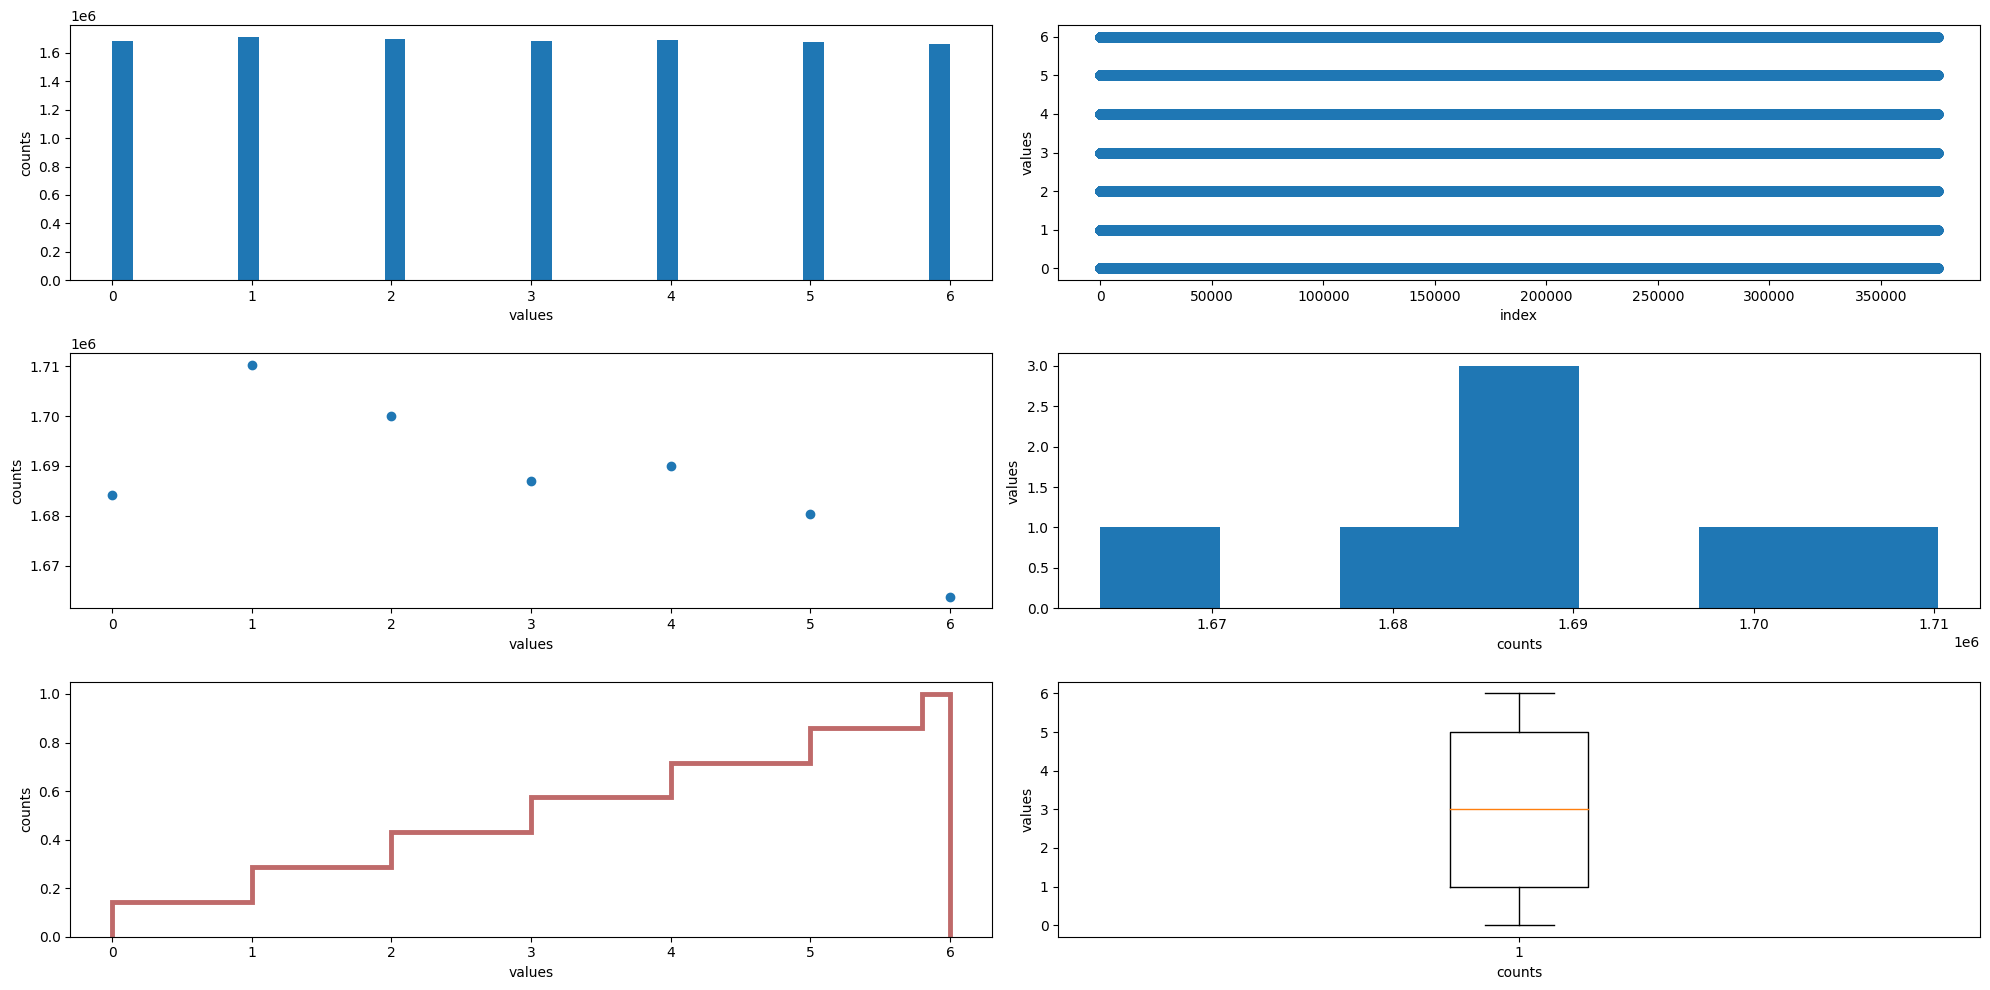

CPU times: user 22.5 s, sys: 1.72 s, total: 24.2 s
Wall time: 48.8 s


In [31]:
%%time
print(stats.describe(filtered_bbdd.dayofweek))
filtered_bbdd.dayofweek.describe()
show_counts(filtered_bbdd.dayofweek.compute())

#### 'day'

DescribeResult(nobs=11815577, minmax=(1.0, 31.0), mean=15.70710689795344, variance=76.64728232875437, skewness=0.00652123858462423, kurtosis=-1.1784504746674305)


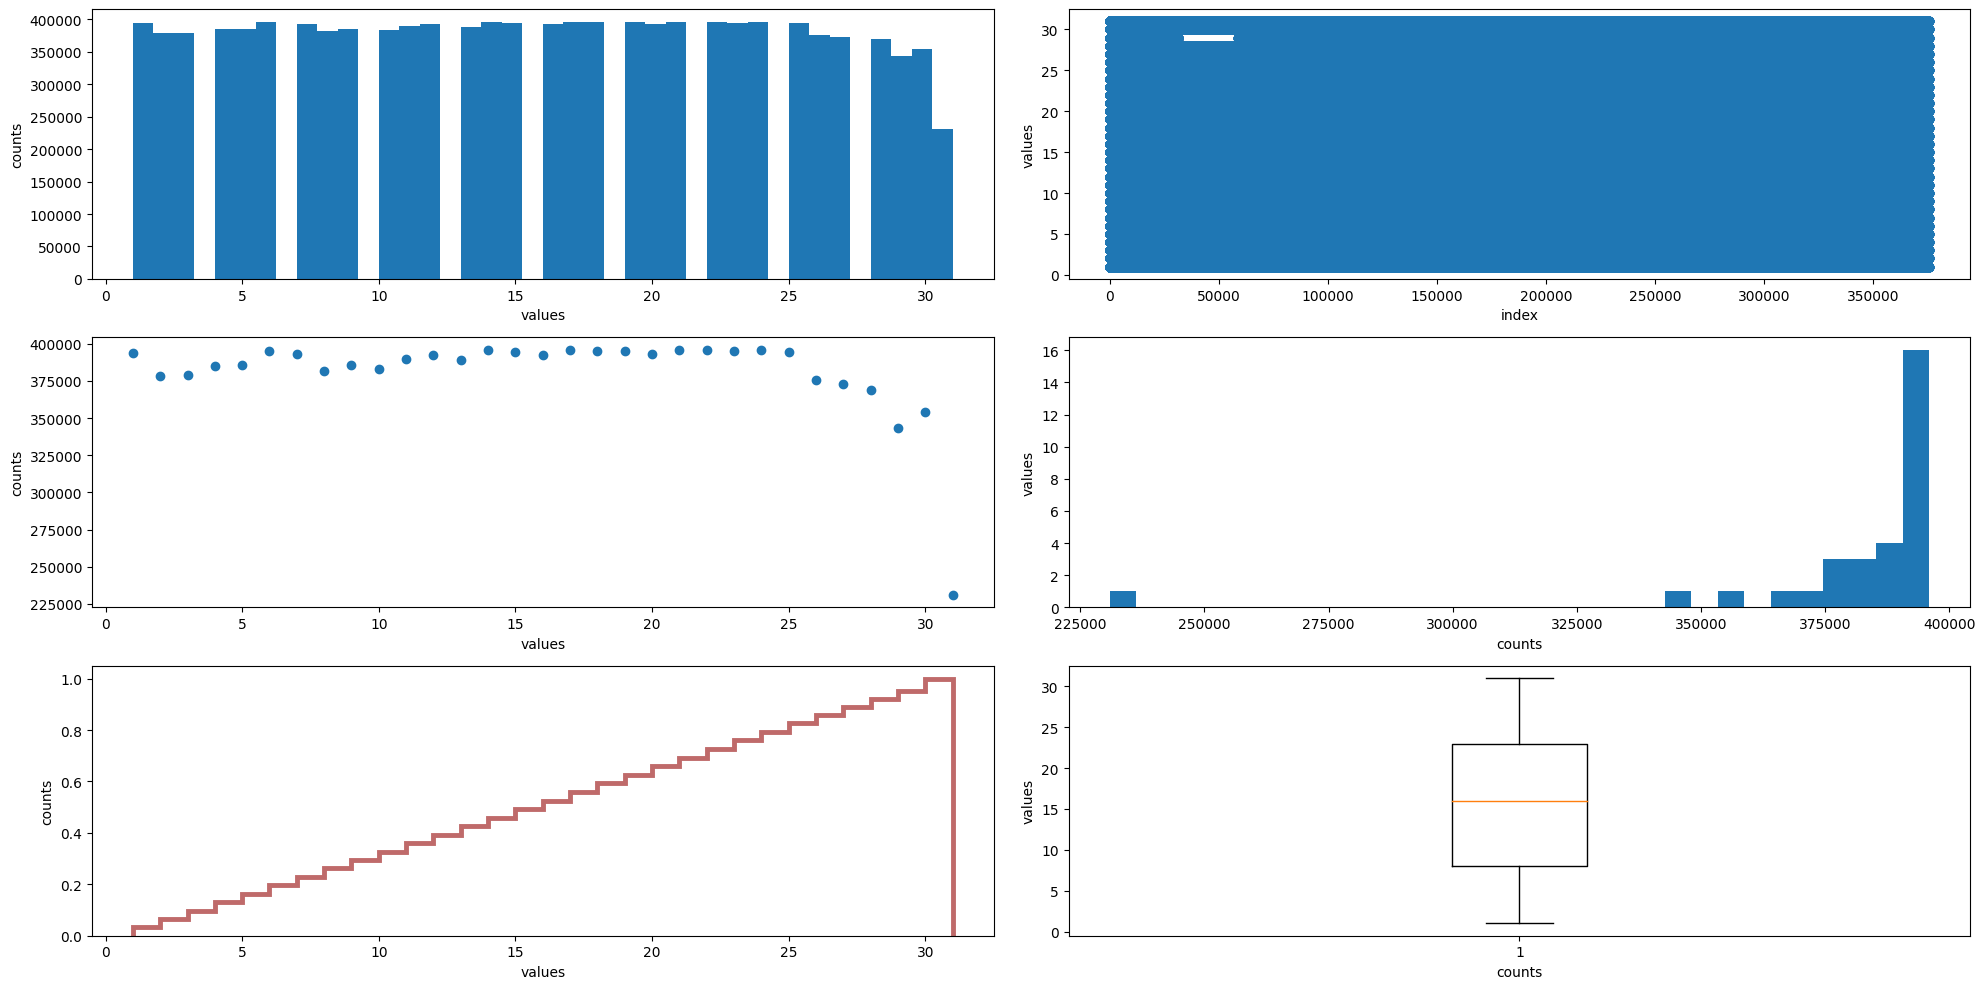

CPU times: user 22.8 s, sys: 1.63 s, total: 24.4 s
Wall time: 50.2 s


In [32]:
%%time
print(stats.describe(filtered_bbdd.day))
filtered_bbdd.day.describe()
show_counts(filtered_bbdd.day.compute())

#### 'dayofyear' 

DescribeResult(nobs=11815577, minmax=(1.0, 365.0), mean=170.82516486499136, variance=11265.3887598391, skewness=0.16821317746436526, kurtosis=-1.1999456071412362)


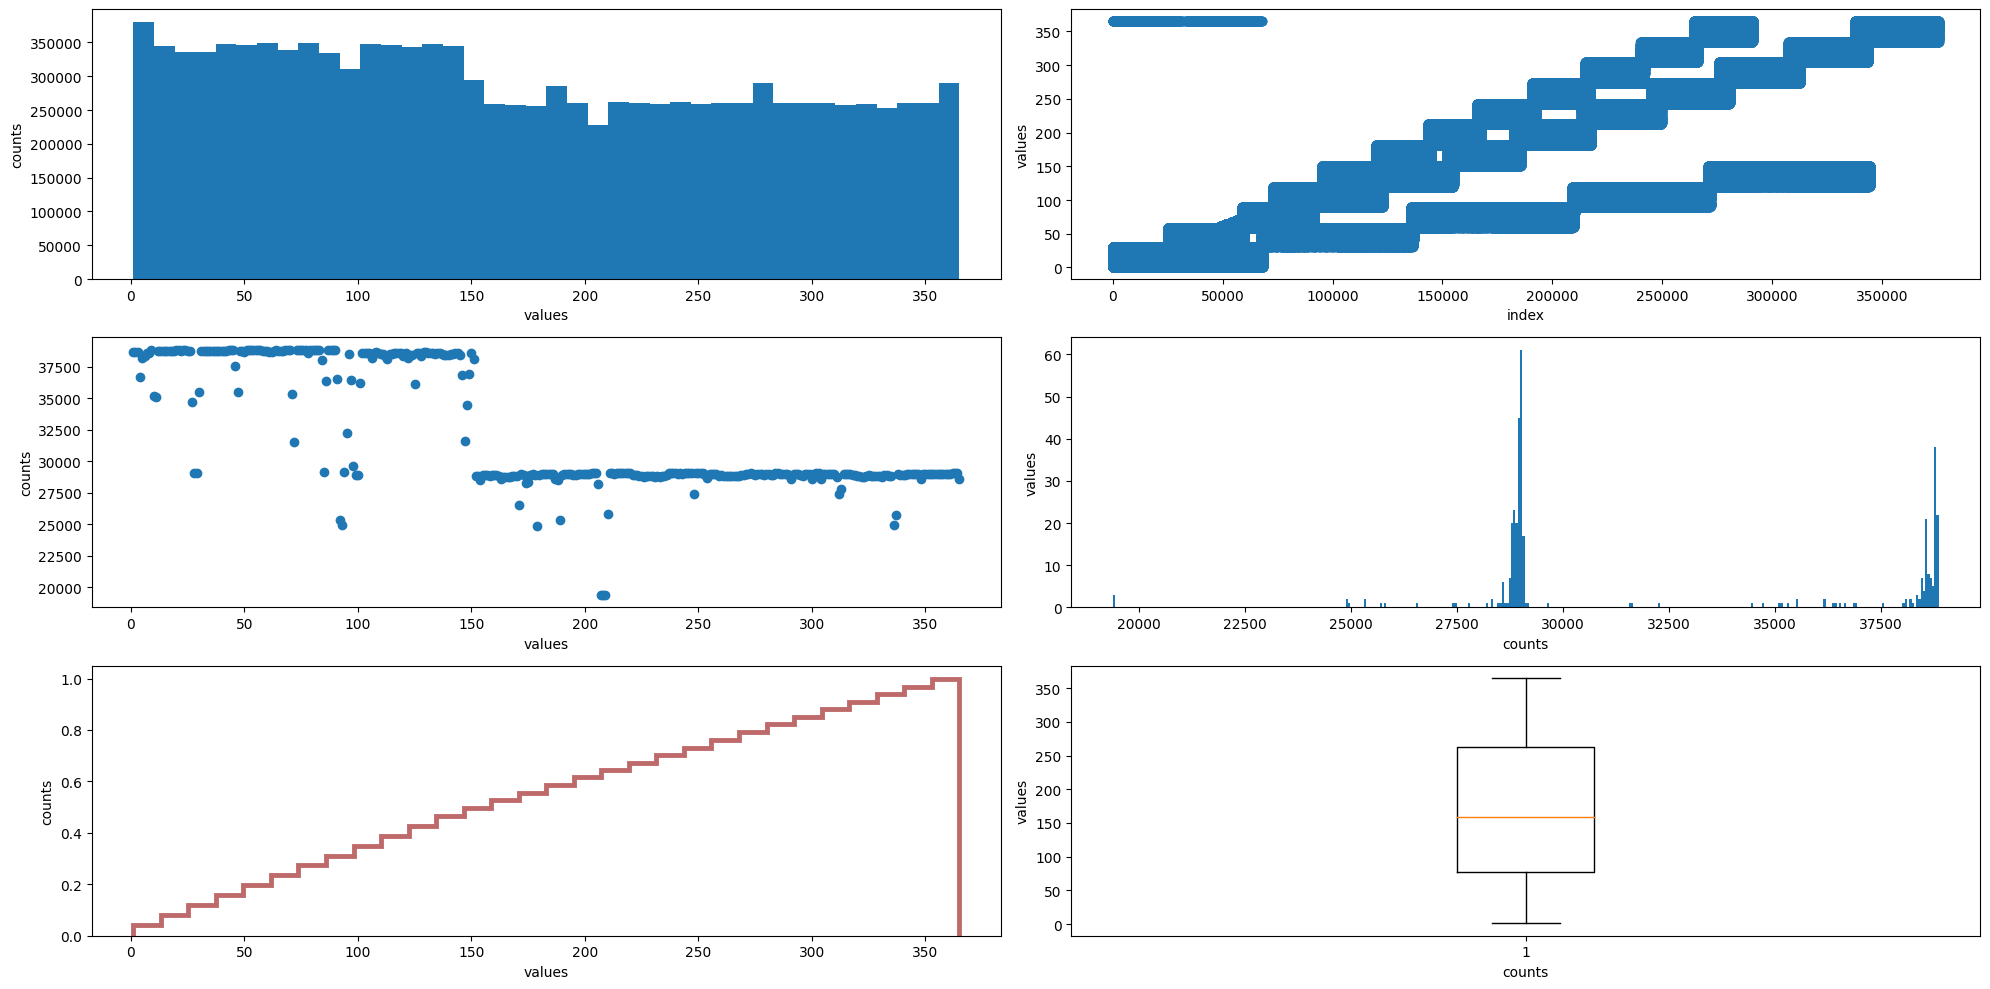

CPU times: user 23.6 s, sys: 1.66 s, total: 25.2 s
Wall time: 49.8 s


In [33]:
%%time
print(stats.describe(filtered_bbdd.dayofyear))
filtered_bbdd.dayofyear.describe()
show_counts(filtered_bbdd.dayofyear.compute())

#### 'hour'

DescribeResult(nobs=11815577, minmax=(0.0, 23.0), mean=11.513686212700405, variance=47.80316431849795, skewness=-0.003023593373171023, kurtosis=-1.2011888168492442)


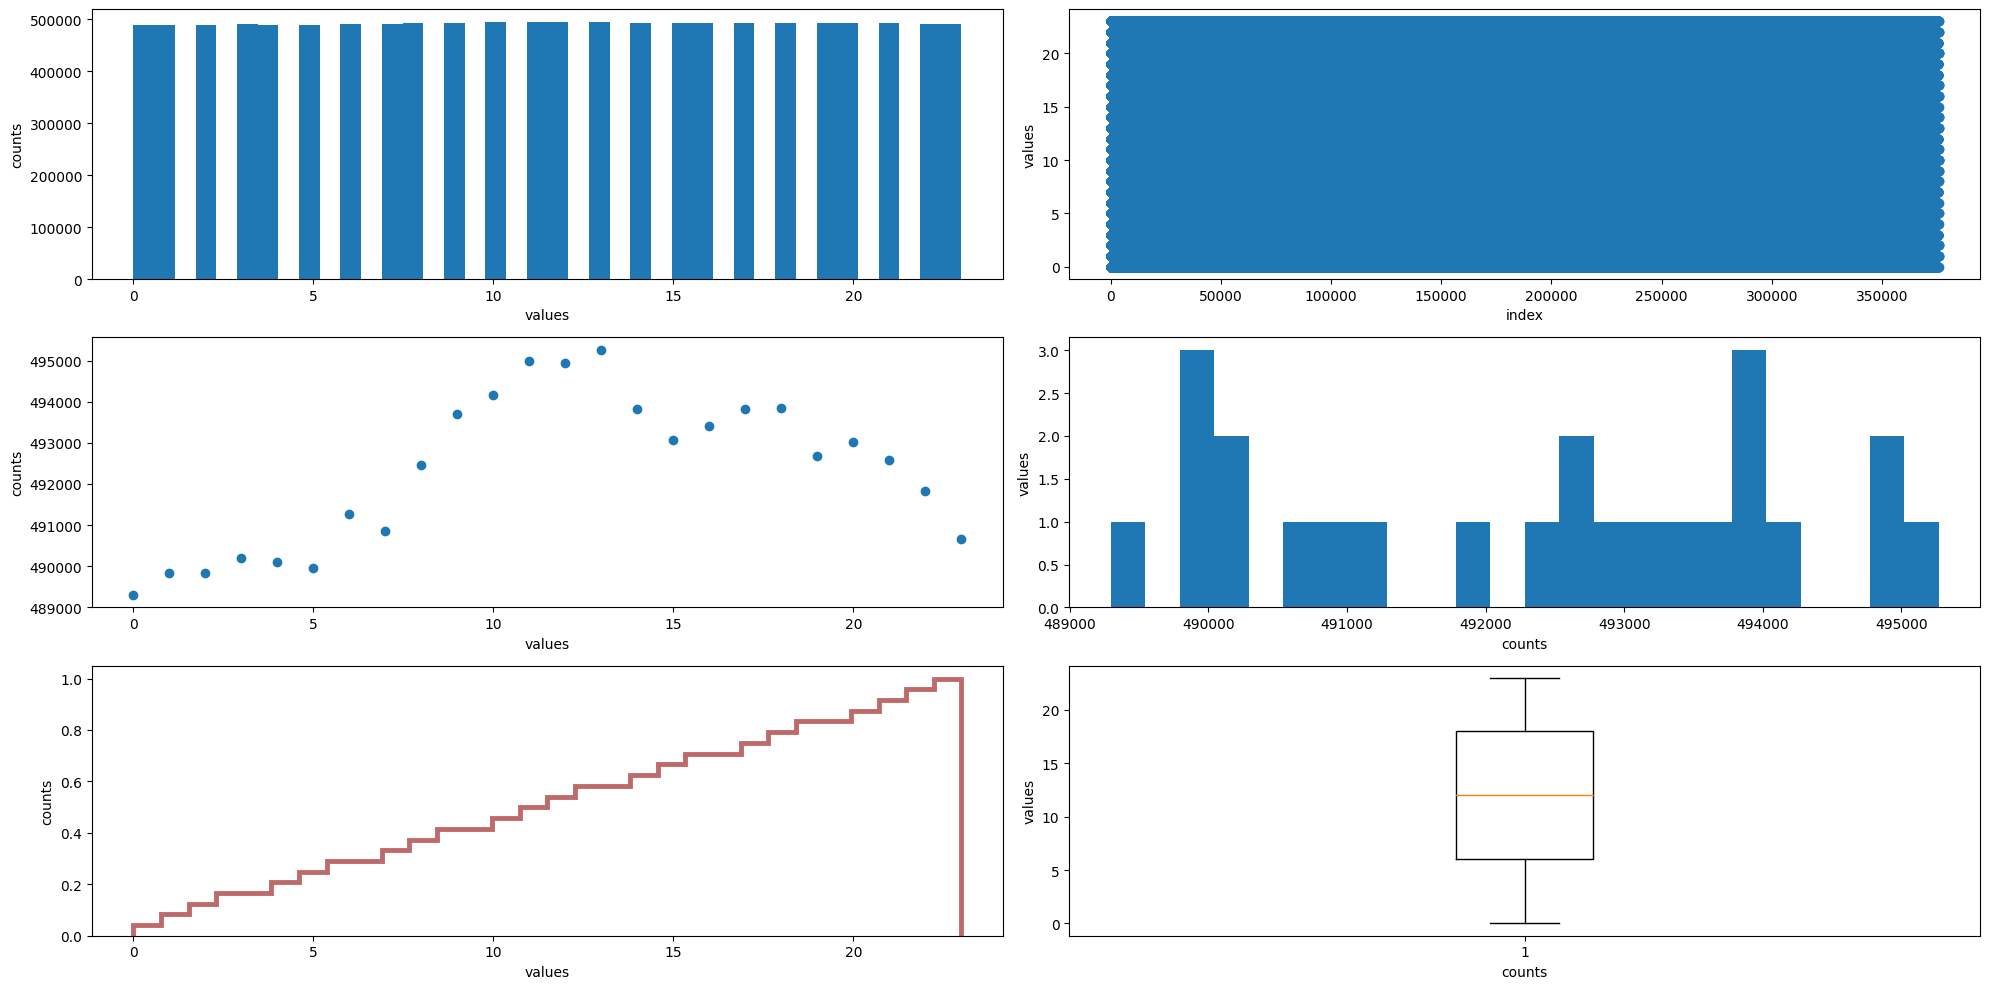

CPU times: user 22.4 s, sys: 1.63 s, total: 24.1 s
Wall time: 49.3 s


In [34]:
%%time
print(stats.describe(filtered_bbdd.hour))
filtered_bbdd.hour.describe()
show_counts(filtered_bbdd.hour.compute())

### Status Columns 

#### 'status'

DescribeResult(nobs=11815577, minmax=(0.0, 1.0), mean=0.9635895902502265, variance=0.0350846947809868, skewness=-4.94999588769521, kurtosis=22.502459288201464)


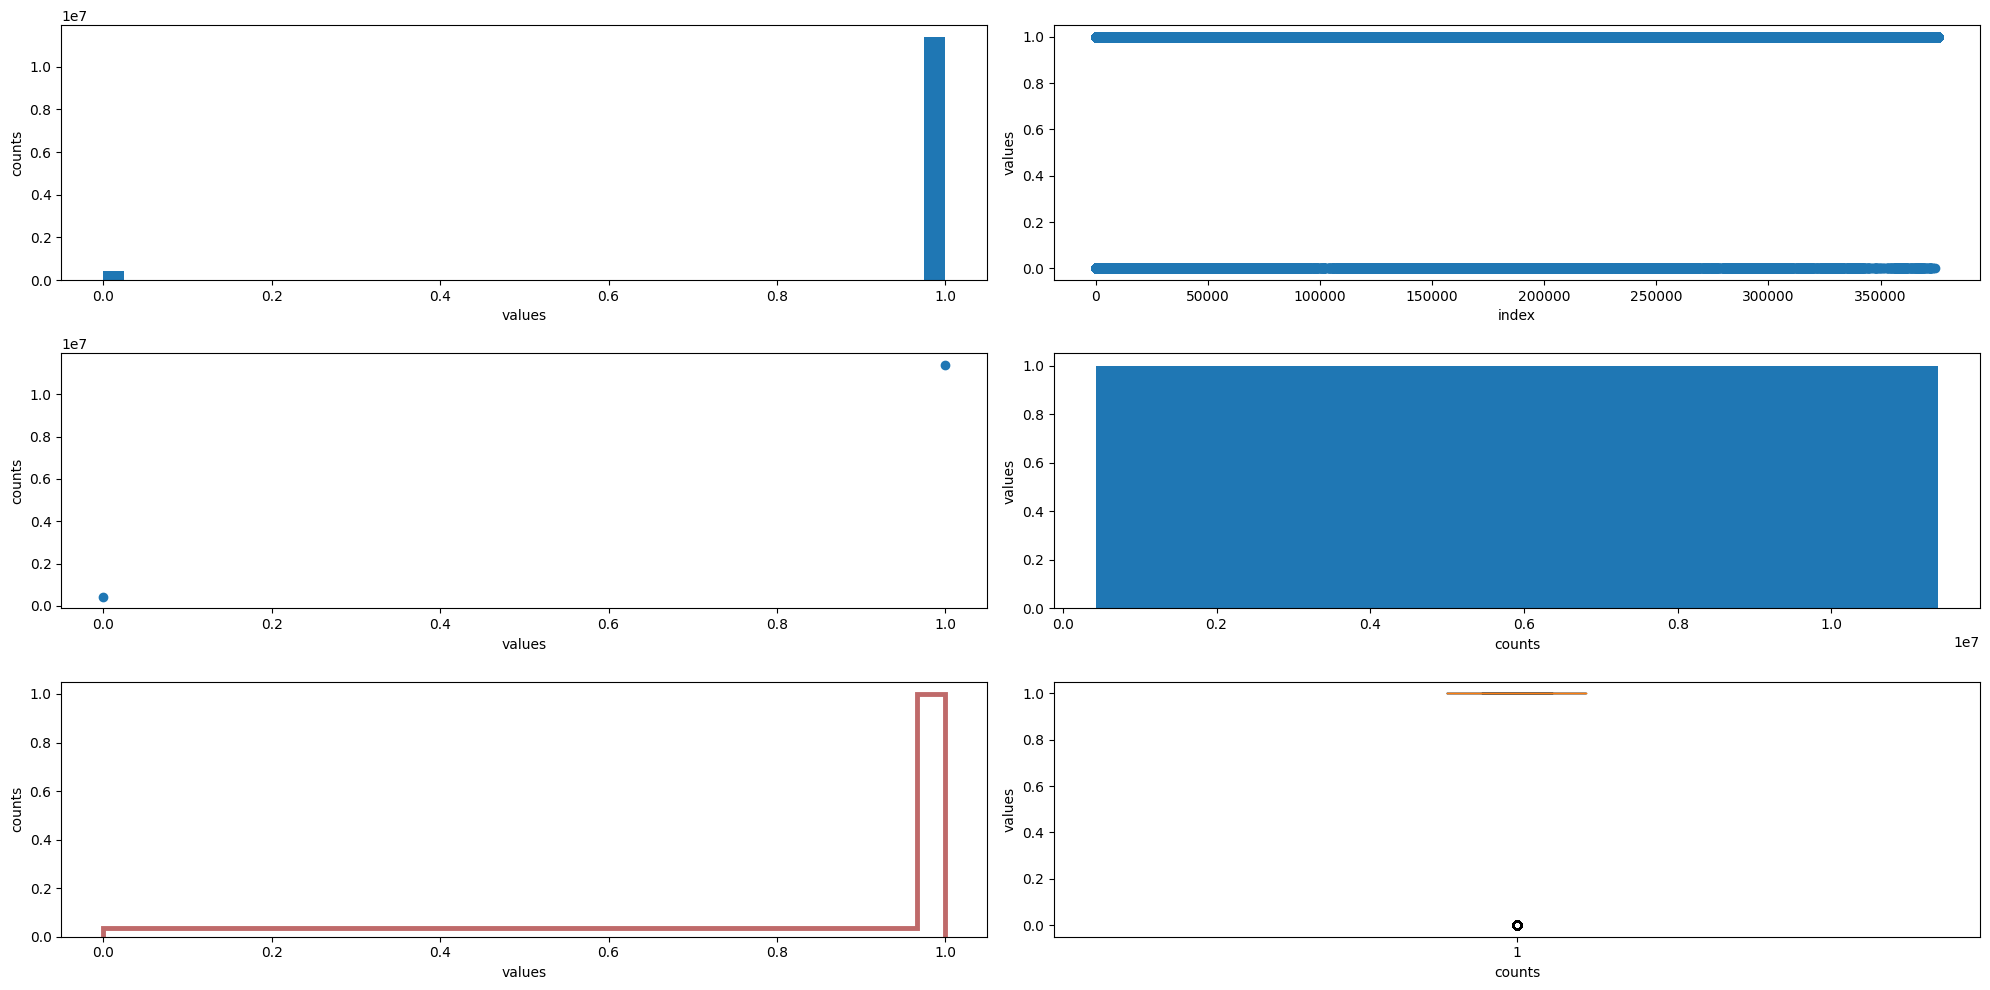

CPU times: user 23.2 s, sys: 1.51 s, total: 24.7 s
Wall time: 49.8 s


In [35]:
%%time
print(stats.describe(filtered_bbdd.status))
filtered_bbdd.status.describe()
show_counts(filtered_bbdd.status.compute())

#### 'is_installed'

#### 'is_renting'

DescribeResult(nobs=11815577, minmax=(0.0, 1.0), mean=0.999362028616969, variance=0.0006375644295051462, skewness=-39.55336983136852, kurtosis=1562.4690650170119)


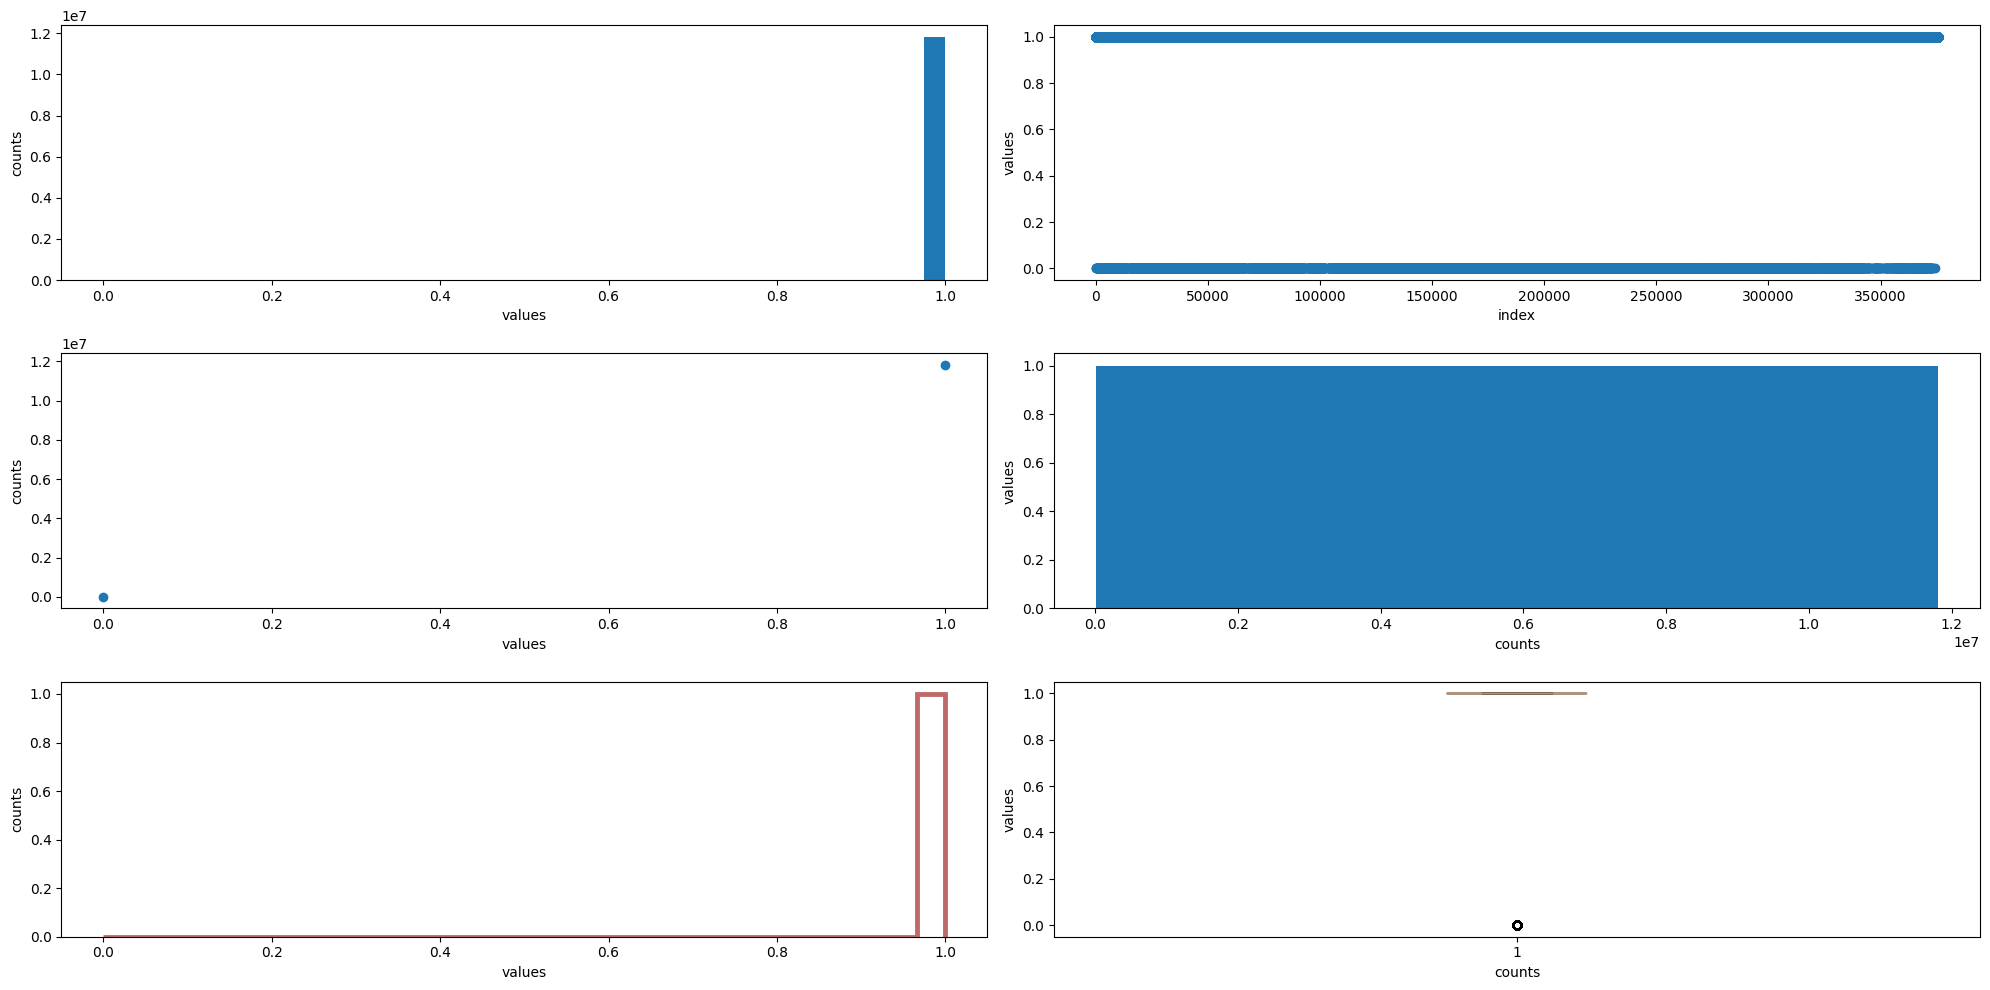

CPU times: user 22.2 s, sys: 1.6 s, total: 23.8 s
Wall time: 48.8 s


In [36]:
%%time
print(stats.describe(filtered_bbdd.is_renting))
filtered_bbdd.is_renting.describe()
show_counts(filtered_bbdd.is_renting.compute())

#### 'is_returning'

DescribeResult(nobs=11815577, minmax=(0.0, 1.0), mean=0.999362874957355, variance=0.0006367191682131262, skewness=-39.57968226986293, kurtosis=1564.5512485832758)


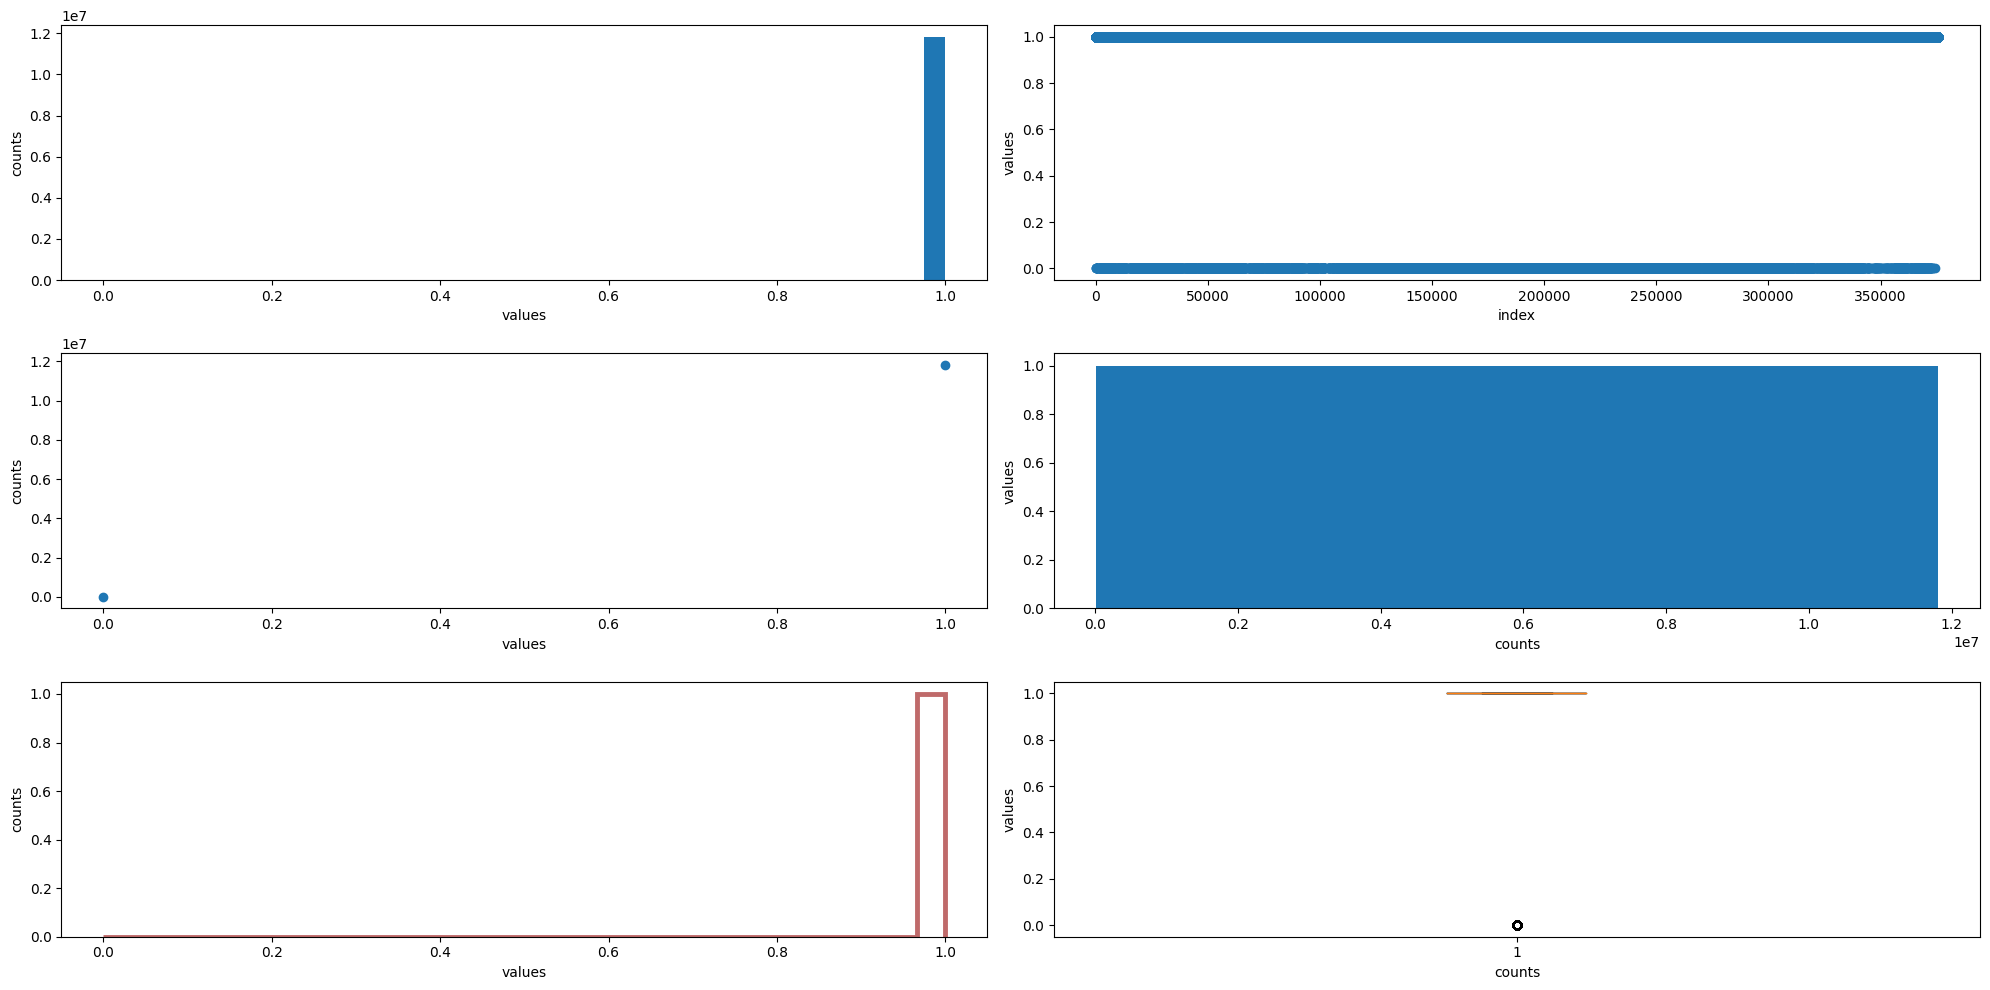

CPU times: user 22.2 s, sys: 1.65 s, total: 23.9 s
Wall time: 49.7 s


In [37]:
%%time
print(stats.describe(filtered_bbdd.is_returning))
filtered_bbdd.is_returning.describe()
show_counts(filtered_bbdd.is_returning.compute())

#### 'is_charging_station'

#### Study  
'status',
'is_renting', 
'is_returning'

In [38]:
def filter_data(data, row_data, row_index):
    cat_cols = row_data.select_dtypes(include=['object']).columns
    num_cols = row_data.select_dtypes(exclude=['object']).columns
    
    filtered = data.copy()
    
    row = row_data.loc[row_index]
    for num_col in num_cols:
        filtered = filtered[filtered[num_col] == row[num_col]]
    
    for cat_col in cat_cols:
        filtered = filtered[filtered[cat_col].isin(row[cat_col])]
    
    return filtered

In [39]:
filtered_bbdd.groupby(
    [         
        'status',
        'is_renting', 
        'is_returning'
    ]
).station_id.sum().compute().reset_index().sort_values(['status','is_renting','is_returning']).reset_index(drop=True)


,status,is_renting,is_returning,station_id
0,0.0,0.0,0.0,1.460160e+06
1,0.0,1.0,1.0,9.274418e+07
2,1.0,0.0,0.0,1.456950e+05
3,1.0,0.0,1.0,2.533000e+03
4,1.0,1.0,1.0,2.460696e+09


In [40]:
status_of_station = filtered_bbdd.groupby(
    [         
        'status',
        'is_renting', 
        'is_returning'
    ]
)['station_id'].unique().compute()

status_of_station = pd.DataFrame(status_of_station).reset_index()
status_of_station = status_of_station.sort_values(['status','is_renting','is_returning']).reset_index(drop=True)
status_of_station

,status,is_renting,is_returning,station_id
0,0.0,0.0,0.0,"[406, 332, 54, 346, 344, 42, 339, 298, 290, 71..."
1,0.0,1.0,1.0,"[1, 318, 311, 310, 321, 307, 305, 304, 302, 29..."
2,1.0,0.0,0.0,"[396, 222, 89, 184, 351, 187, 424, 307, 23, 12..."
3,1.0,0.0,1.0,"[94, 352, 223, 42, 351, 404, 78, 220, 345, 424]"
4,1.0,1.0,1.0,"[1, 320, 319, 318, 317, 316, 315, 314, 313, 31..."


In [41]:
## view of the stations status

value counts stats {'max': 101, 'mean': 16.883663366336634, 'median': 13.0, 'std': 14.8982930874196, 'min': 1}


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 52.1 s, sys: 5.59 s, total: 57.7 s
Wall time: 5min 27s


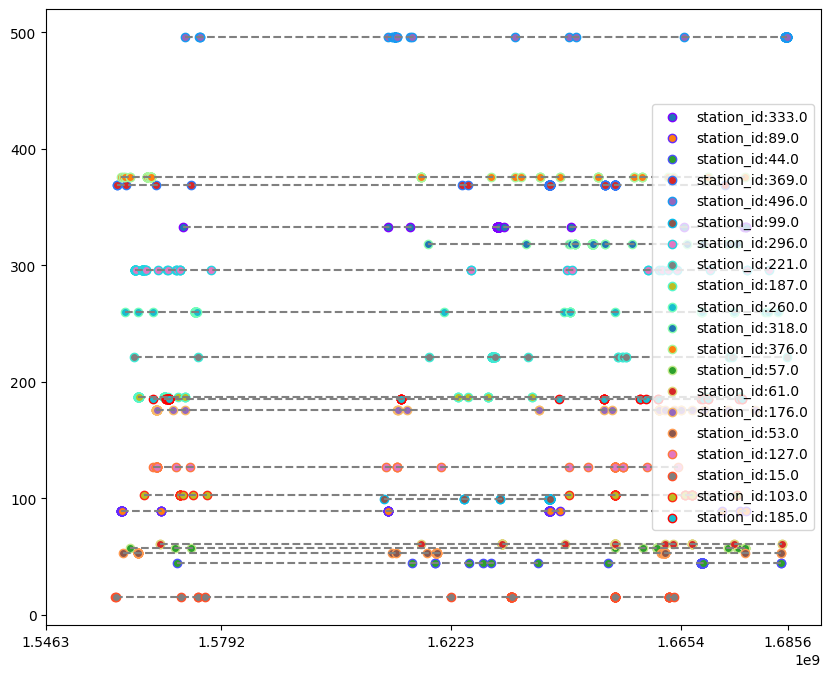

In [42]:
%%time

# status(r) 	is_renting 	is_returning 	
# 0.0 	          0.0 	        0.0 	
filtered = filter_data(filtered_bbdd, status_of_station, 0)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=xticks,
    figsize=(10,8),
    count=20
)

value counts stats {'max': 2119, 'mean': 1045.404938271605, 'median': 1031.0, 'std': 518.8096943826841, 'min': 179}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 14.8 s, sys: 1.56 s, total: 16.3 s
Wall time: 1min 32s


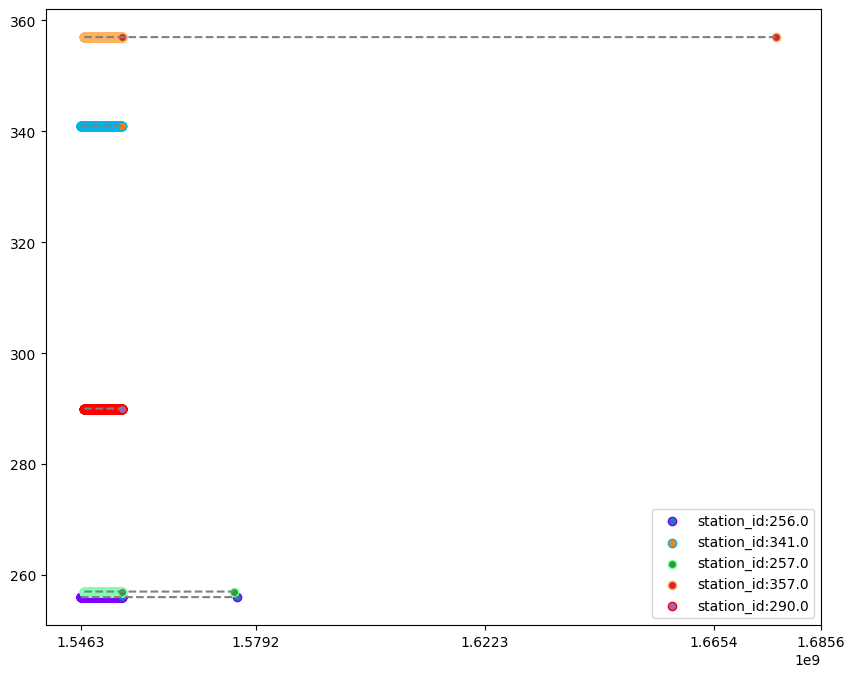

In [43]:
%%time

# status(r) 	is_renting 	is_returning 	
# 0.0 	1.0 	1.0
filtered = filter_data(filtered_bbdd, status_of_station, 1)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 8, 'mean': 2.1956521739130435, 'median': 2.0, 'std': 1.3633771440417985, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 15.1 s, sys: 1.5 s, total: 16.6 s
Wall time: 1min 34s


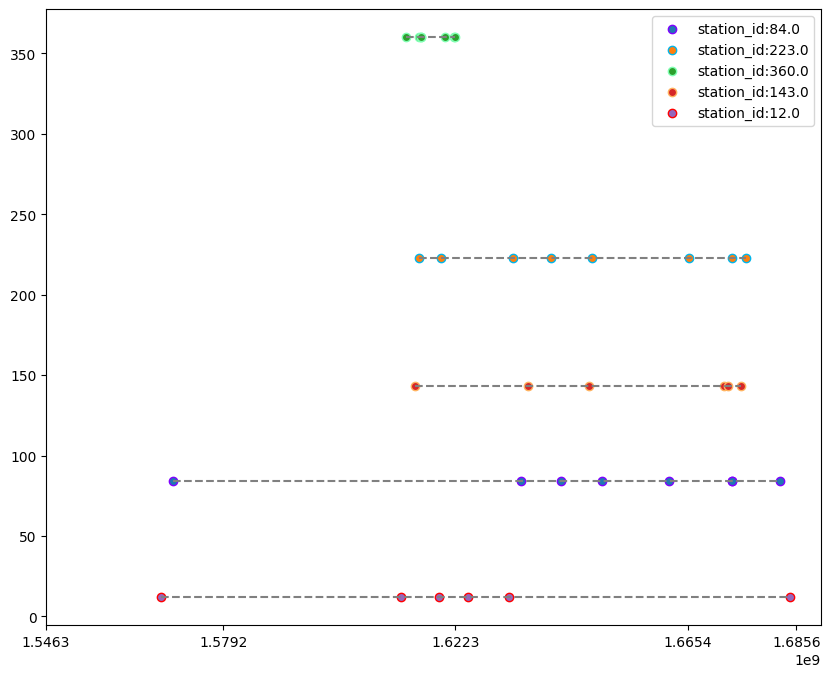

In [44]:
%%time

# status(r) 	is_renting 	is_returning 	
# 1.0 	0.0 	0.0
filtered = filter_data(filtered_bbdd, status_of_station, 2)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 1, 'mean': 1.0, 'median': 1.0, 'std': 0.0, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 15.1 s, sys: 1.43 s, total: 16.5 s
Wall time: 1min 35s


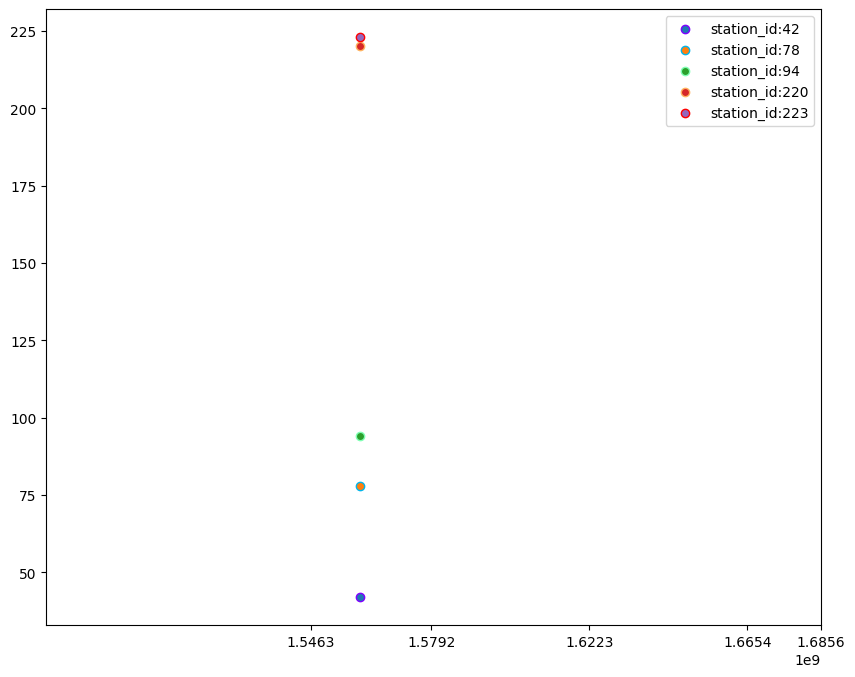

In [45]:
%%time

# status(r) 	is_renting 	is_returning 	
# 1.0 	0.0 	1.0
filtered = filter_data(filtered_bbdd, status_of_station, 3)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

### Goal Columns 

#### 'num_docks_available' 

DescribeResult(nobs=11815577, minmax=(0.0, 54.0), mean=15.686748120593897, variance=75.02236154356203, skewness=0.11717587971367234, kurtosis=-0.31426629832060016)


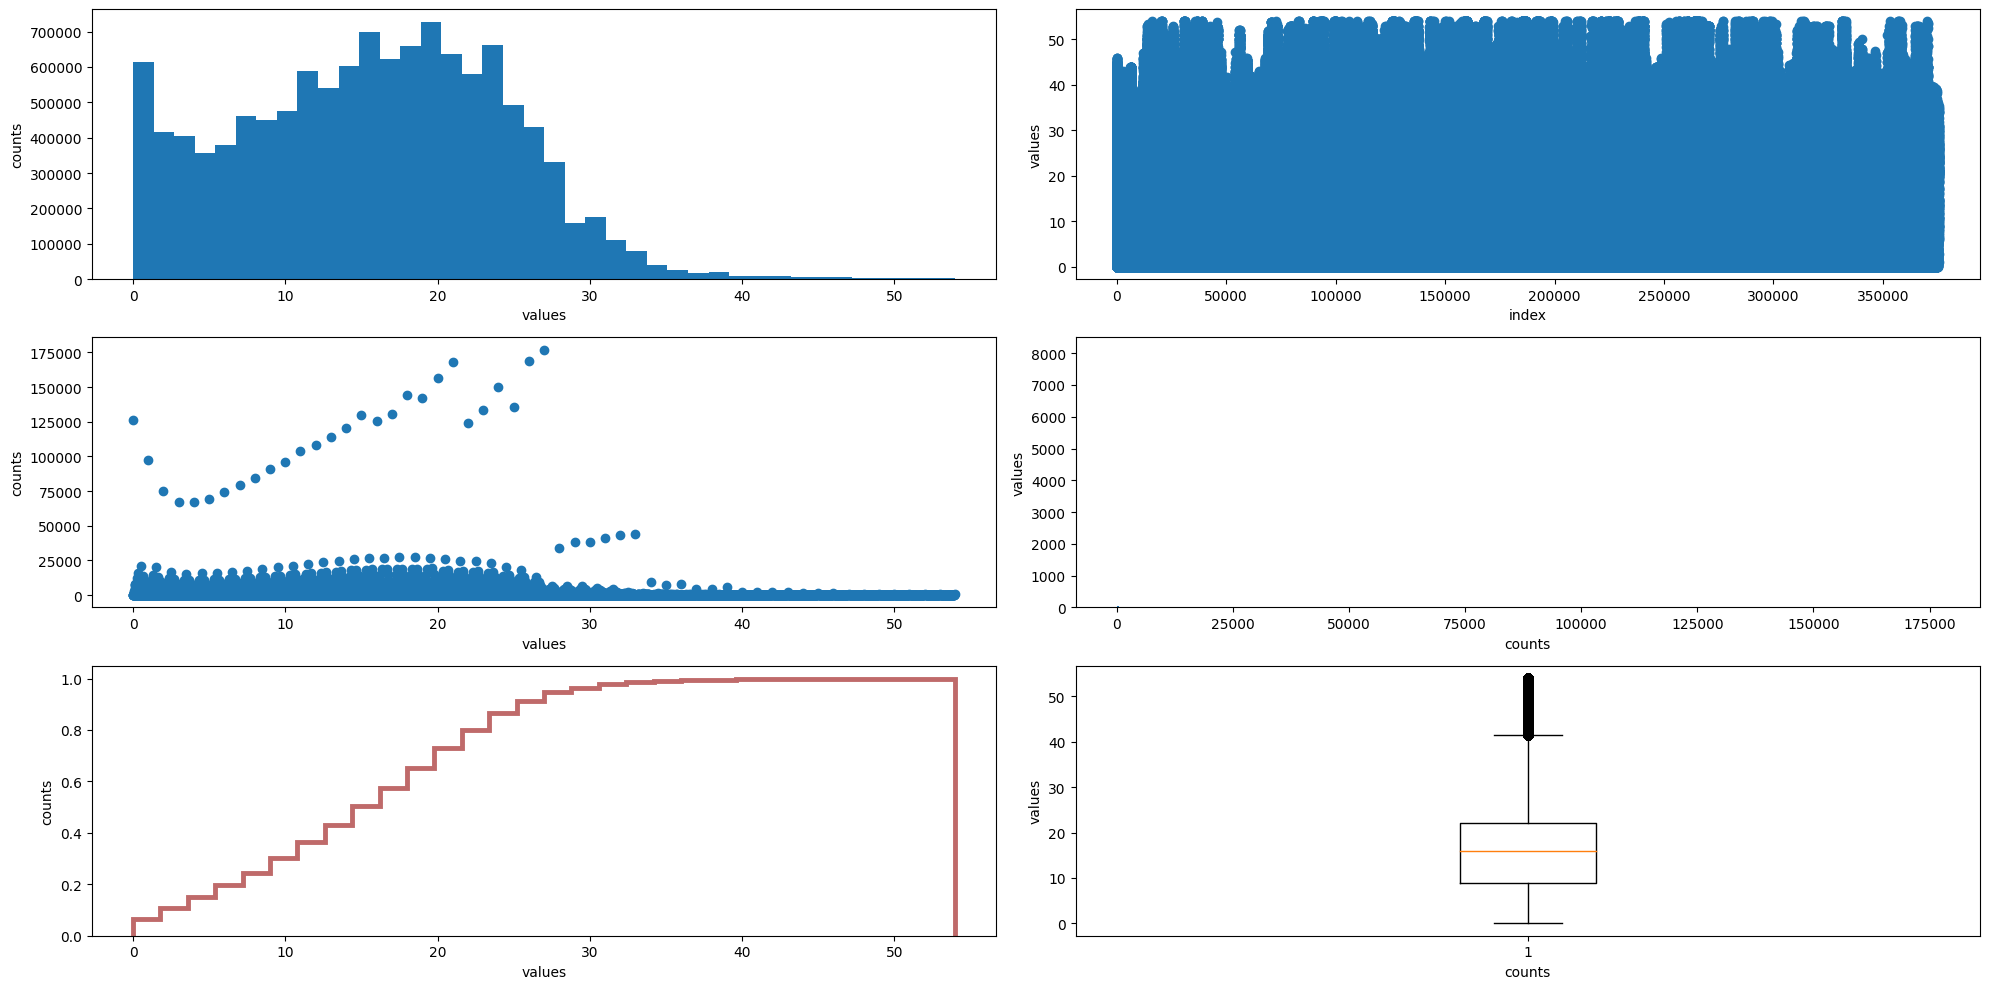

CPU times: user 36.1 s, sys: 3.22 s, total: 39.3 s
Wall time: 1min 1s


In [46]:
%%time
print(stats.describe(filtered_bbdd.num_docks_available))
filtered_bbdd.num_docks_available.describe()
show_counts(filtered_bbdd.num_docks_available.compute())

#### 'num_bikes_available' 

DescribeResult(nobs=11815577, minmax=(-0.1666666666666666, 54.0), mean=10.046599952137024, variance=70.33929434895518, skewness=0.8449071647966168, kurtosis=0.47762436735195823)


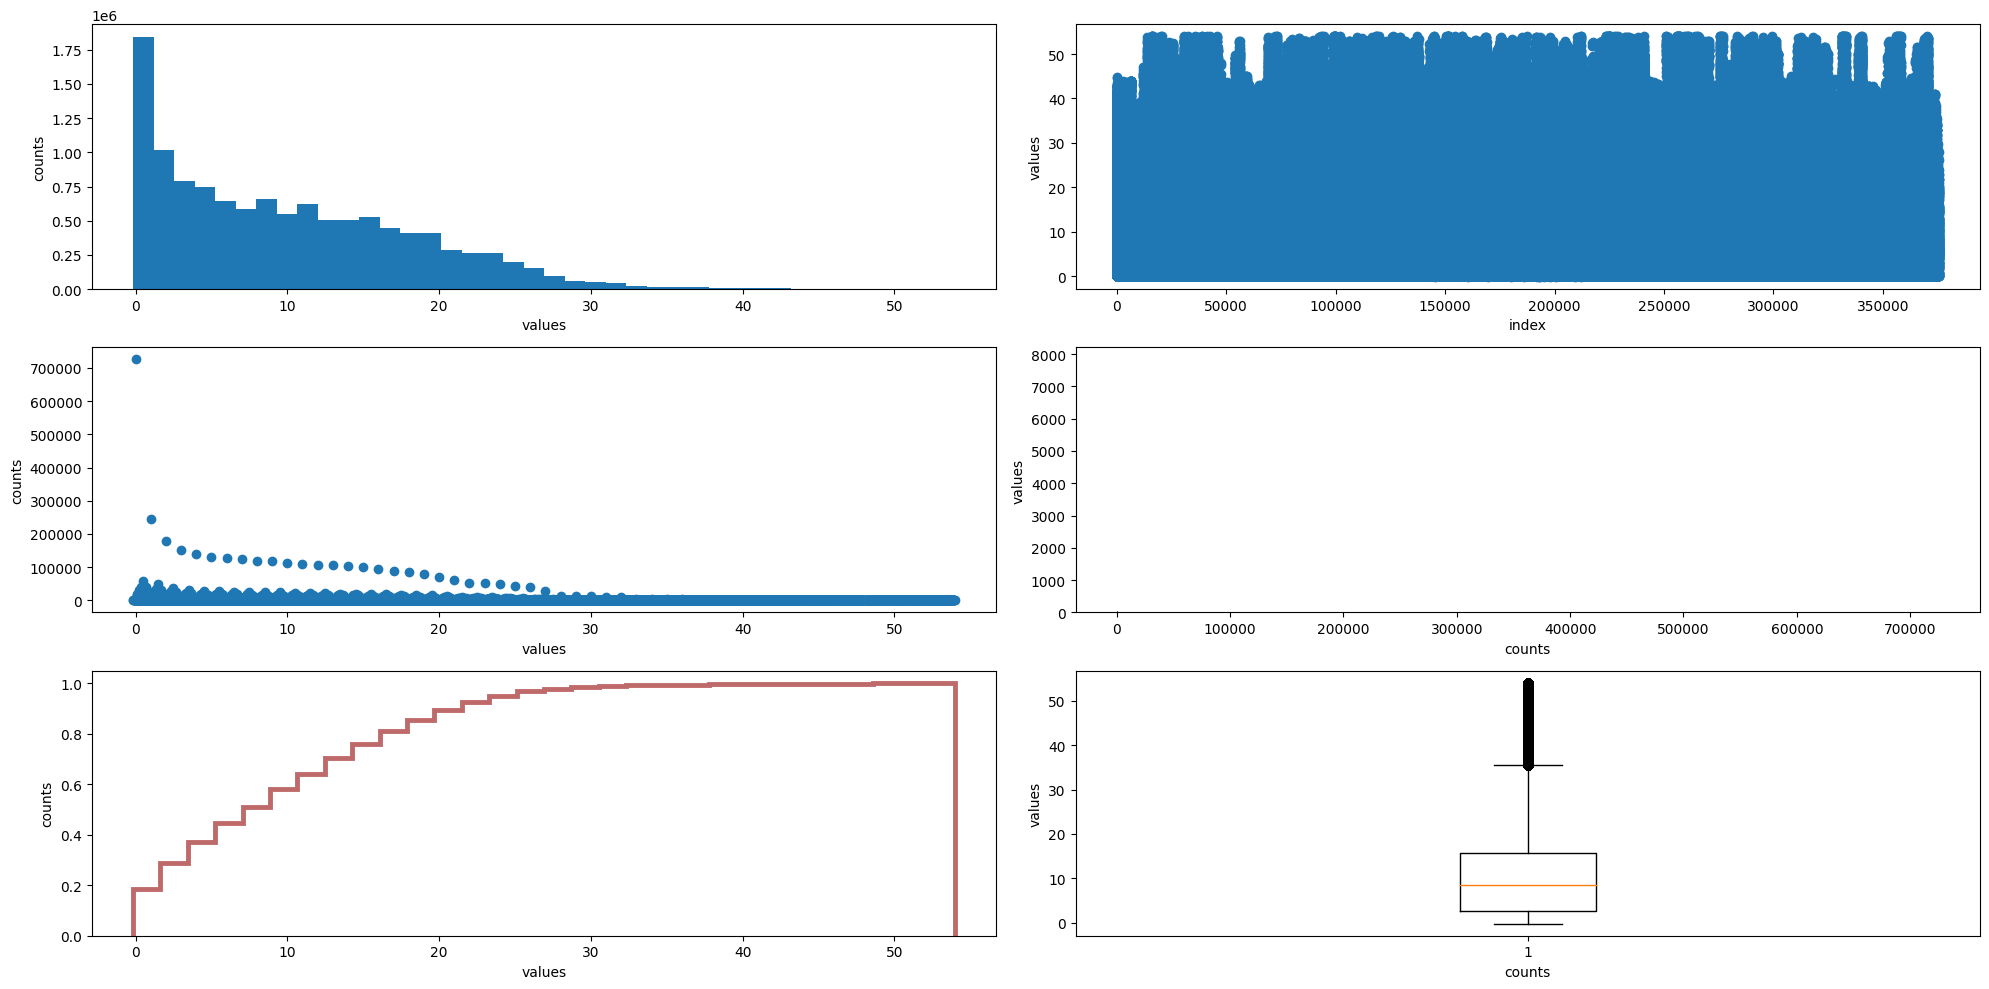

CPU times: user 34.5 s, sys: 2.89 s, total: 37.4 s
Wall time: 1min


In [47]:
%%time
print(stats.describe(filtered_bbdd.num_bikes_available))
filtered_bbdd.num_bikes_available.describe()
show_counts(filtered_bbdd.num_bikes_available.compute())

#### 'num_bikes_available_types.mechanical'

DescribeResult(nobs=11815577, minmax=(-0.1666666666666666, 54.0), mean=8.242624989676333, variance=64.55853400385794, skewness=1.013656025713014, kurtosis=0.7112424140196878)


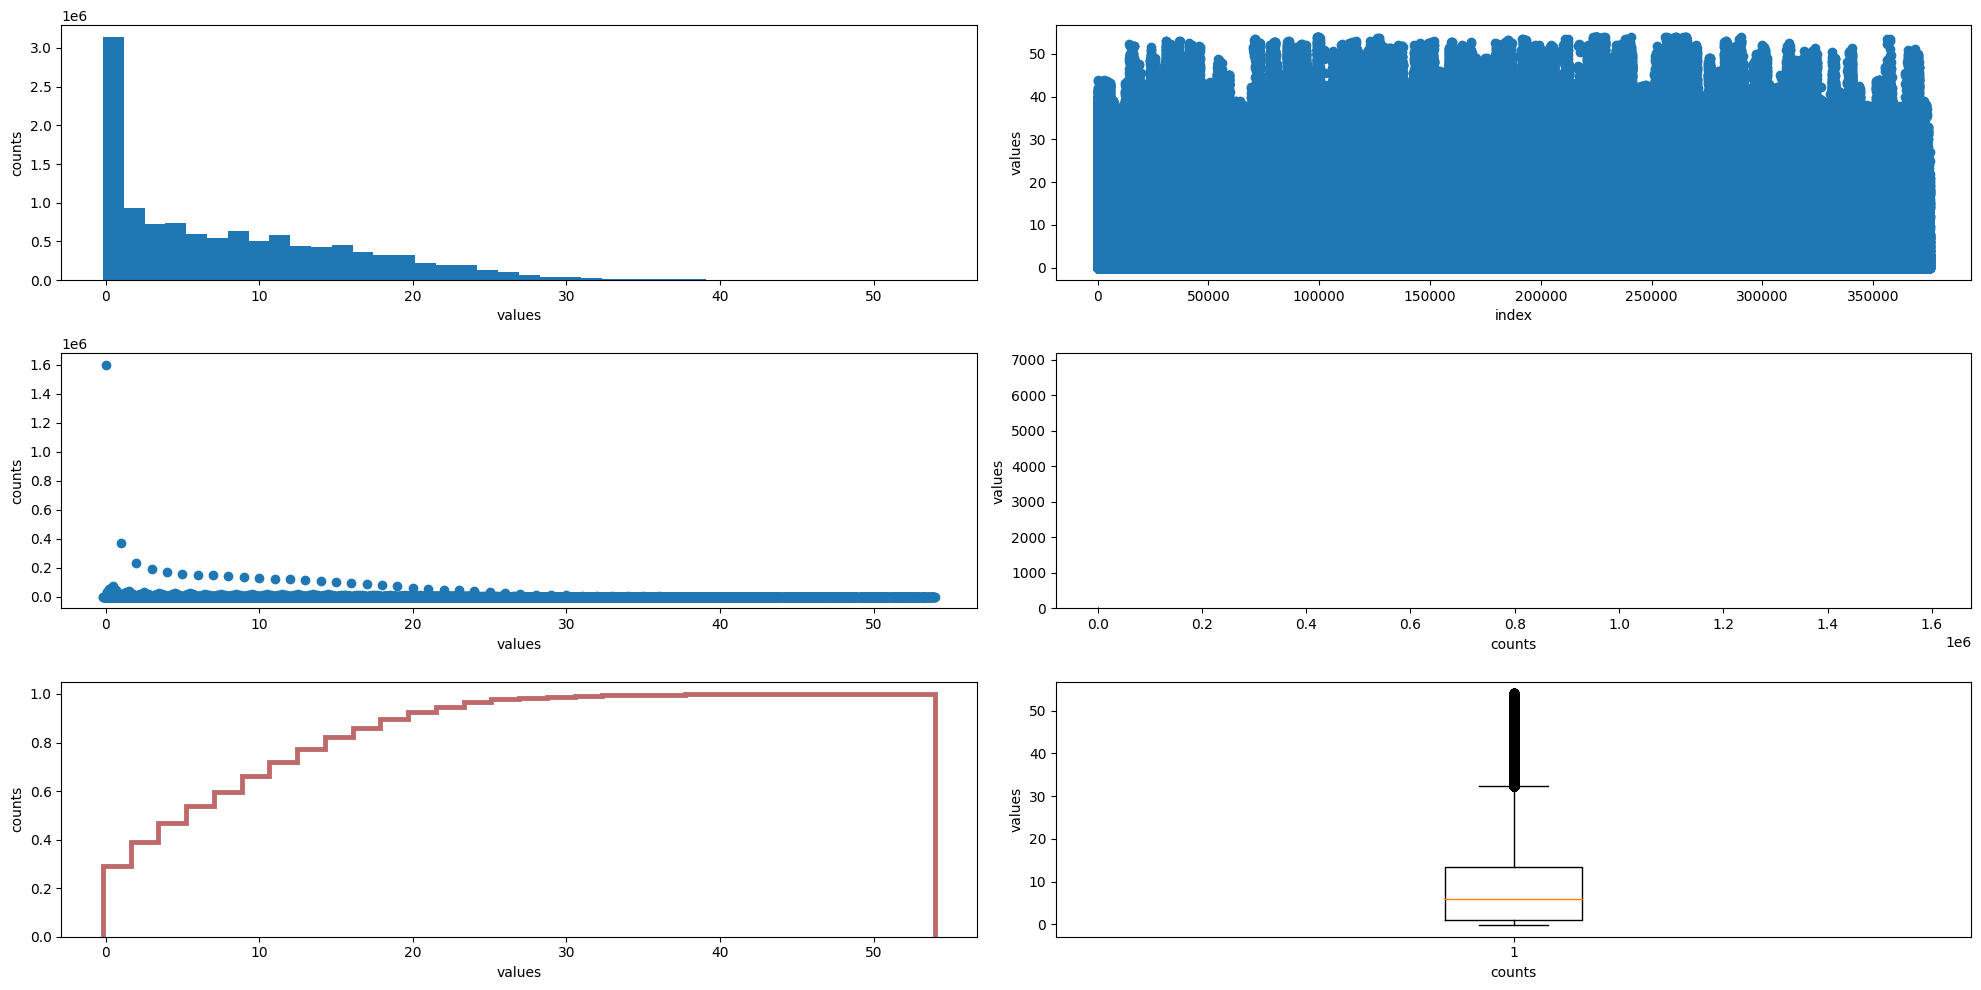

CPU times: user 32.6 s, sys: 2.74 s, total: 35.4 s
Wall time: 59.2 s


In [48]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.mechanical']))
filtered_bbdd['num_bikes_available_types.mechanical'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.mechanical'].compute())

#### 'num_bikes_available_types.ebike'

DescribeResult(nobs=11815577, minmax=(0.0, 45.14285714285714), mean=1.8040083868451333, variance=8.83724045295154, skewness=3.06304815212141, kurtosis=12.27166382918411)


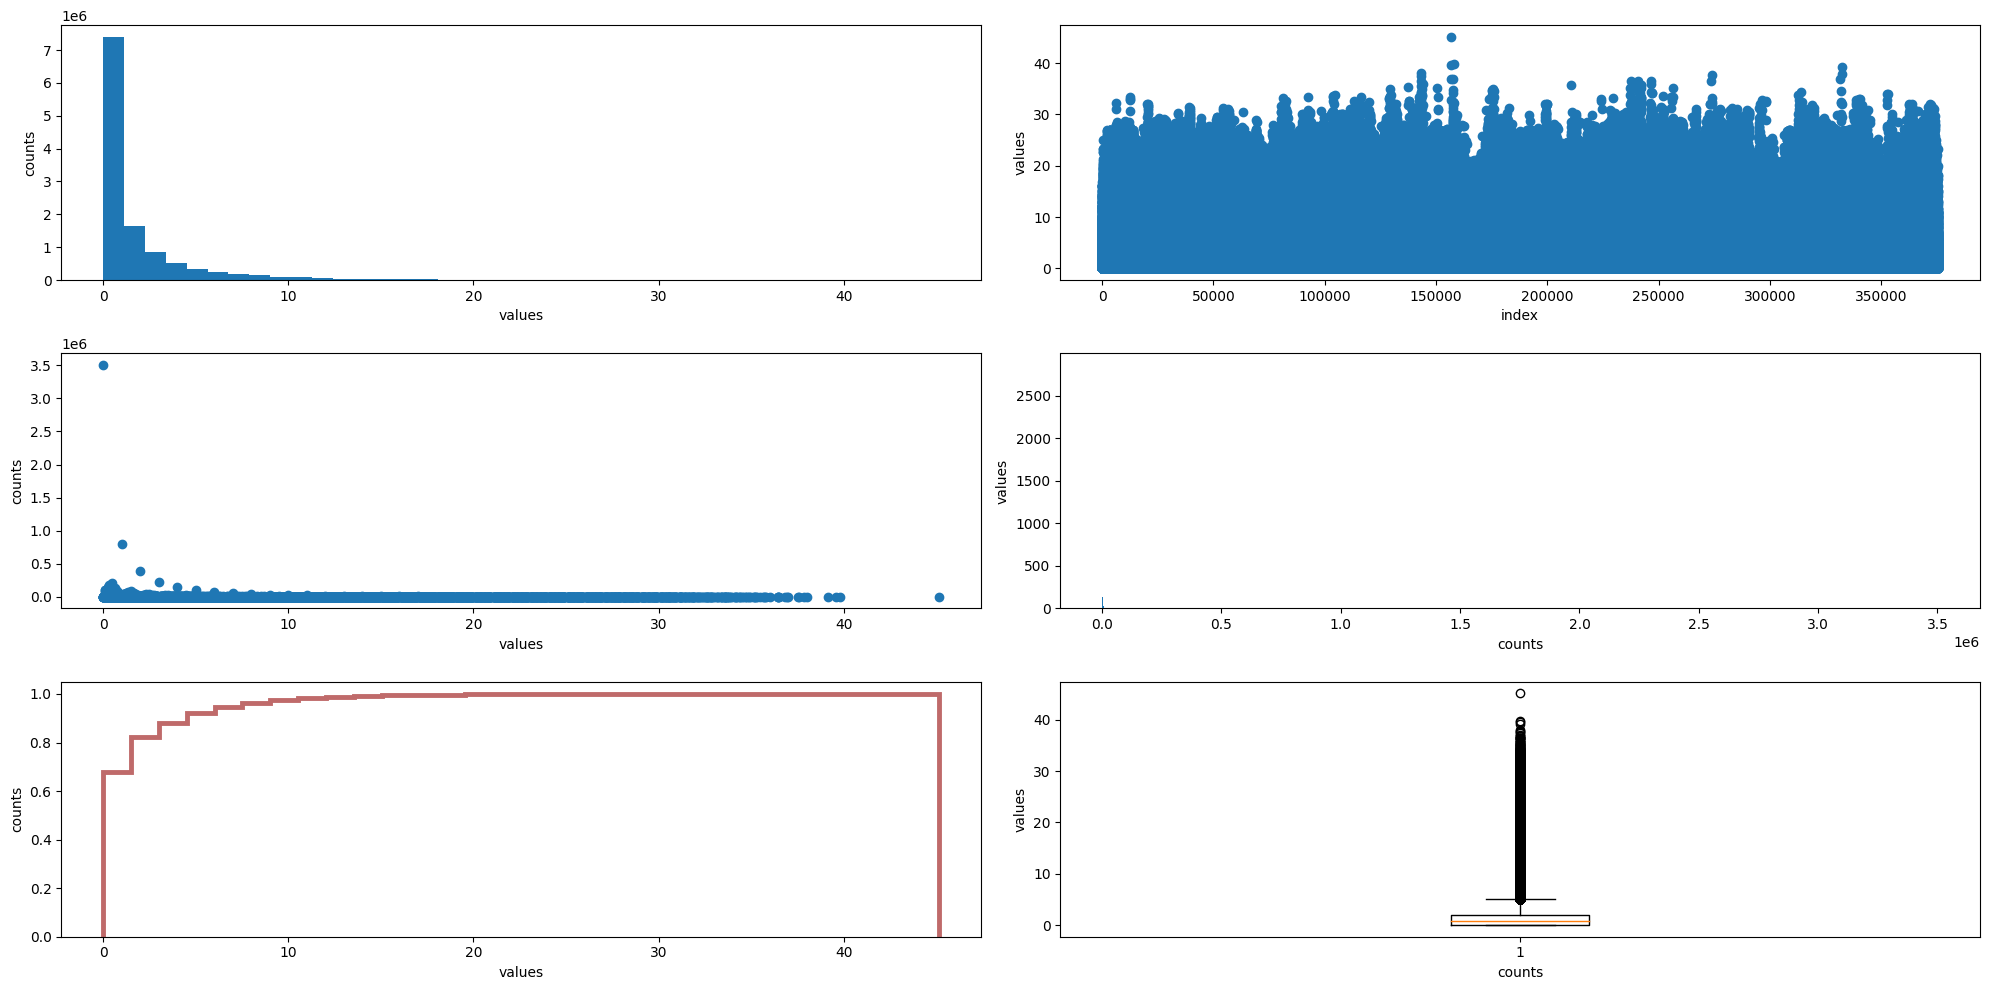

CPU times: user 27.2 s, sys: 2.09 s, total: 29.3 s
Wall time: 53.3 s


In [49]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.ebike']))
filtered_bbdd['num_bikes_available_types.ebike'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.ebike'].compute())

#### 'capacity' 

DescribeResult(nobs=11815577, minmax=(12.000000000000004, 54.00000000000003), mean=27.38478580911119, variance=36.83628174432861, skewness=1.3246283515445036, kurtosis=3.874748507645185)


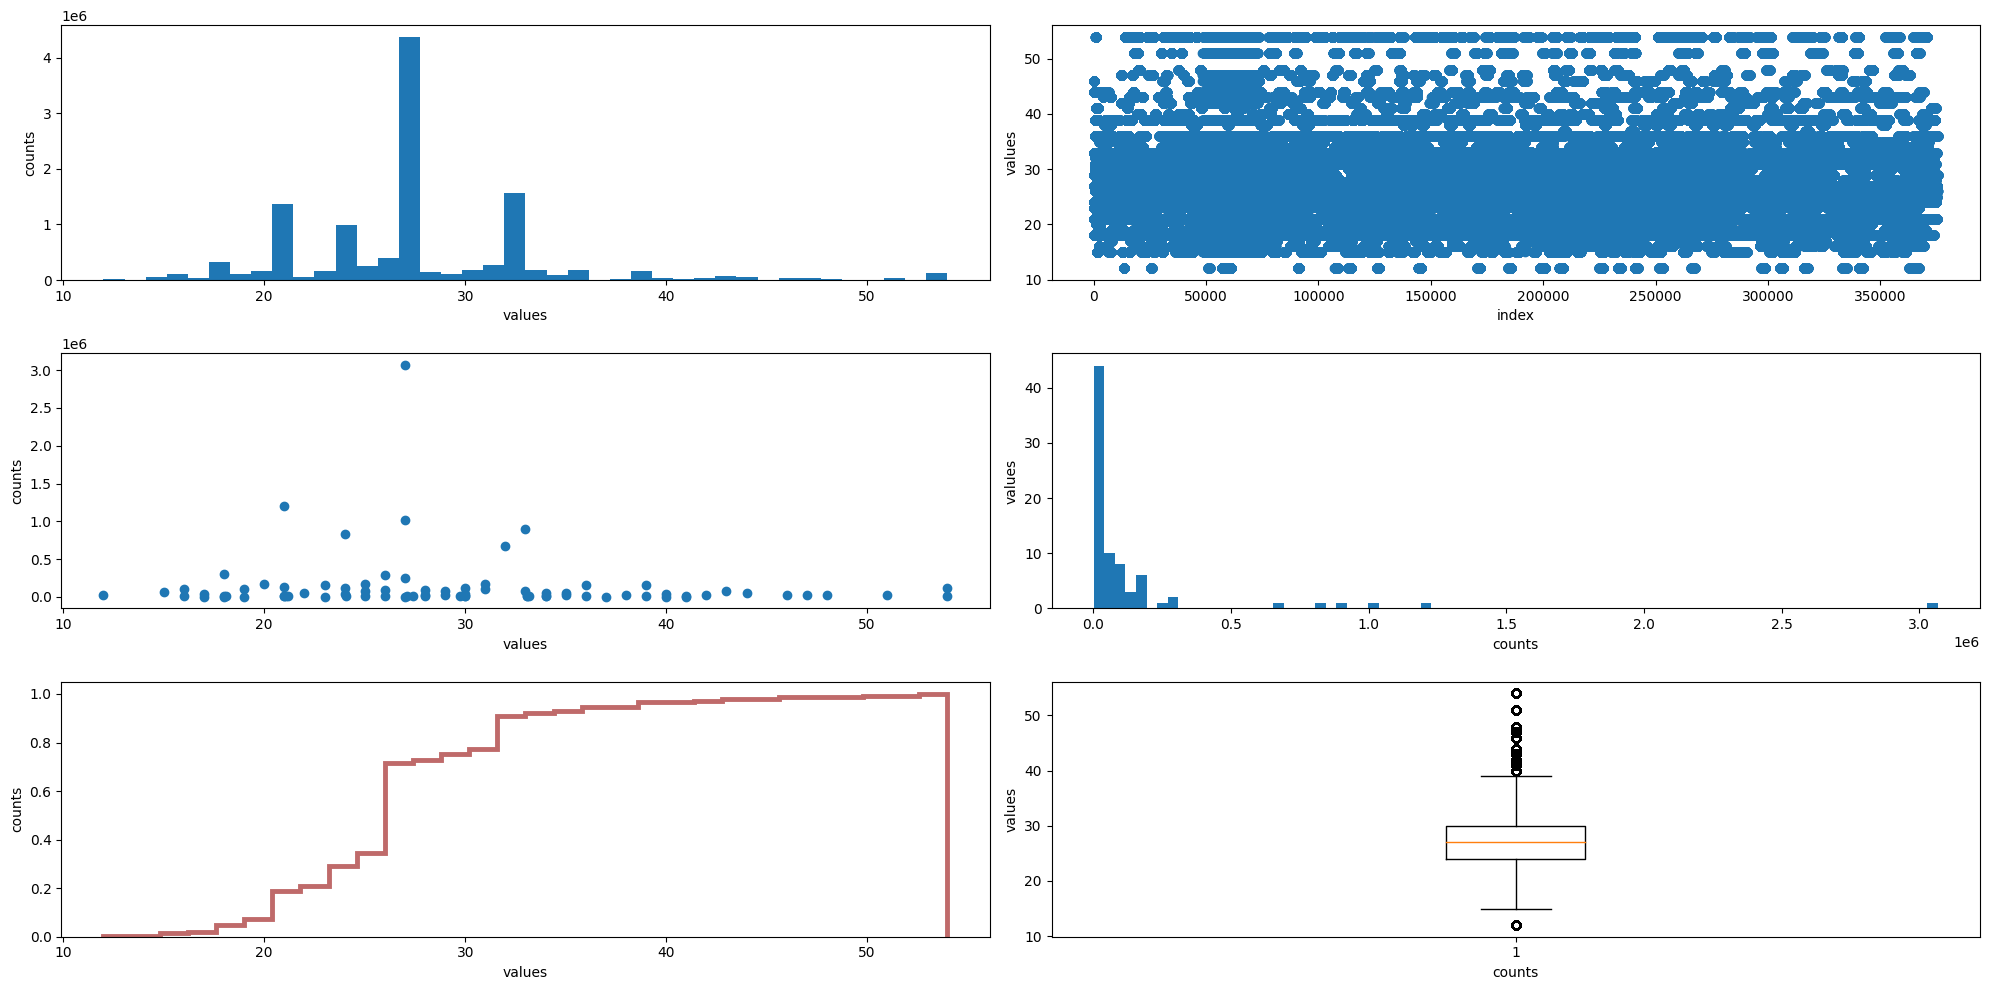

CPU times: user 22.9 s, sys: 1.59 s, total: 24.5 s
Wall time: 49.7 s


In [50]:
%%time
print(stats.describe(filtered_bbdd.capacity))
filtered_bbdd.capacity.describe()
show_counts(filtered_bbdd.capacity.compute())

#### 'ctx0'

DescribeResult(nobs=11815577, minmax=(0.0, 1.0), mean=0.5726913636075398, variance=0.08353715334935477, skewness=-0.3700611760299128, kurtosis=-1.011110645176293)


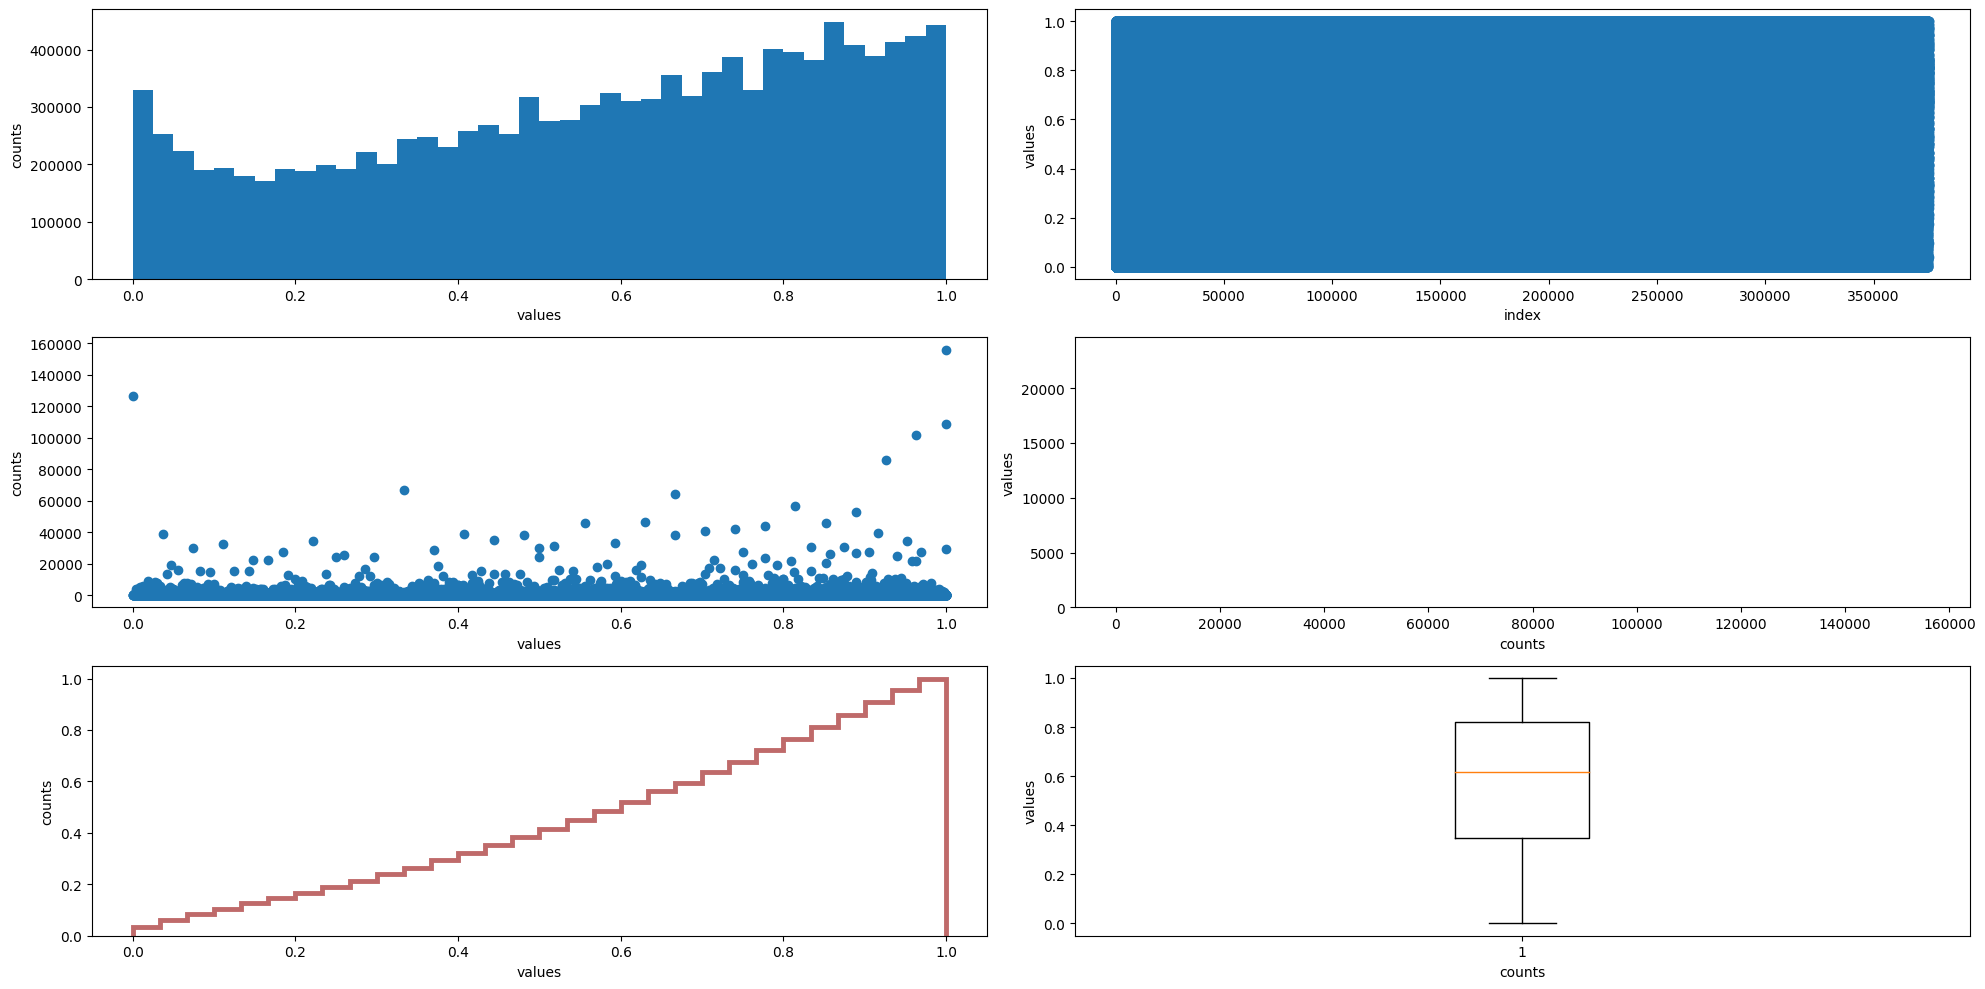

CPU times: user 1min 50s, sys: 12 s, total: 2min 2s
Wall time: 2min 15s


In [51]:
%%time
print(stats.describe(filtered_bbdd.ctx0))
filtered_bbdd.ctx0.describe()
show_counts(filtered_bbdd.ctx0.compute())

## · Visualización de la disponibilidad de bicicletas
Gráficos para visualizar la disponibilidad de bicicletas a lo largo del tiempo. Ejemplo: cantidad de bicicletas disponibles en función del tiempo para identificar patrones diarios, semanales o estacionales.

In [52]:
client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

## · Análisis temporal
Datos por año, mes, día de la semana o hora del día para conocer estadísticas agregadas, como el promedio de bicicletas disponibles o el porcentaje de anclajes disponibles. Tendencias temporales y patrones de uso.

In [53]:
client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

## · Relación entre variables
Explorar si hay una correlación entre el número de anclajes disponibles (num_docks_available) y el número de bicicletas disponibles (num_bikes_available). Investigar si la disponibilidad de bicicletas difiere entre los diferentes tipos de bicicletas (mecánicas y eléctricas).

In [54]:
client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

In [55]:
#Correlación
def calculate_correlation(data, variable1, variable2):
    correlation = data[variable1].corr(data[variable2]).compute()
    return print(f"Correlación entre {variable1} y {variable2}: {correlation}")


In [56]:
def matriz_correlation(data, variable1, variable2):
    data_subset = data[[variable1, variable2]]
    correlation = data_subset.corr().compute()
    print(correlation)

#### Interpretar correlación
La diagonal principal de la matriz contiene los coeficientes de correlación de cada variable consigo misma, que siempre es 1. Esto es porque una variable está perfectamente correlacionada consigo misma.

La posición (i, j) y (j, i) de la matriz, donde i y j son los índices de las variables que te interesan, contiene el coeficiente de correlación entre esas dos variables. Este coeficiente puede variar entre -1 y 1, y proporciona información sobre la fuerza y la dirección de la relación entre las variables:

- Un coeficiente de correlación de 1 indica una correlación positiva perfecta, lo que significa que cuando una variable aumenta, la otra variable también aumenta en una relación lineal.

- Un coeficiente de correlación de -1 indica una correlación negativa perfecta, lo que significa que cuando una variable aumenta, la otra variable disminuye en una relación lineal.

- Un coeficiente de correlación cercano a 0 indica una correlación débil o nula, lo que significa que no hay una relación lineal aparente entre las variables.

In [57]:
calculate_correlation(filtered_bbdd, 'num_docks_available', 'num_bikes_available')
matriz_correlation(filtered_bbdd, 'num_docks_available', 'num_bikes_available')

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


Correlación entre num_docks_available y num_bikes_available: -0.7322738199342596
                     num_docks_available  num_bikes_available
num_docks_available             1.000000            -0.732274
num_bikes_available            -0.732274             1.000000


In [58]:
calculate_correlation(filtered_bbdd, 'capacity', 'num_bikes_available')
matriz_correlation(filtered_bbdd, 'capacity', 'num_bikes_available')

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


Correlación entre capacity y num_bikes_available: 0.3086717642249116
                     capacity  num_bikes_available
capacity             1.000000             0.308672
num_bikes_available  0.308672             1.000000


In [59]:
calculate_correlation(filtered_bbdd, 'ctx0', 'dayofweek')
matriz_correlation(filtered_bbdd, 'ctx0', 'dayofweek')

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


Correlación entre ctx0 y dayofweek: -0.015190662863821258
               ctx0  dayofweek
ctx0       1.000000  -0.015191
dayofweek -0.015191   1.000000


In [60]:
calculate_correlation(filtered_bbdd, 'num_docks_available', 'dayofweek')
matriz_correlation(filtered_bbdd, 'num_docks_available', 'dayofweek')

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


Correlación entre num_docks_available y dayofweek: -0.015280184479800734
                     num_docks_available  dayofweek
num_docks_available              1.00000   -0.01528
dayofweek                       -0.01528    1.00000


In [61]:
calculate_correlation(filtered_bbdd, 'ctx0', 'hour')
matriz_correlation(filtered_bbdd, 'ctx0', 'hour')

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


Correlación entre ctx0 y hour: 0.02151102571795778
          ctx0      hour
ctx0  1.000000  0.021511
hour  0.021511  1.000000


In [62]:
calculate_correlation(filtered_bbdd, 'num_docks_available', 'hour')
matriz_correlation(filtered_bbdd, 'num_docks_available', 'hour')

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


Correlación entre num_docks_available y hour: 0.019334535420565853
                     num_docks_available      hour
num_docks_available             1.000000  0.019335
hour                            0.019335  1.000000


## · Análisis de capacidad y porcentaje de anclajes disponibles
Capacidad (capacity) y los porcentajes de anclajes disponibles (ctx0, ctx1, ctx2, ctx3, ctx4). Promedio distribución de la capacidad y los porcentajes de anclajes disponibles. Objetivo: entender la utilización de las estaciones de bicicletas a lo largo del tiempo.

In [63]:
client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

In [64]:
capacidad_promedio = filtered_bbdd['capacity'].mean().compute()

distribucion_porcentaje = filtered_bbdd[['ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4']].describe().compute()

print(f"Promedio de la capacidad: {capacidad_promedio}")
print("Distribución de los porcentajes de anclajes disponibles:")
print(distribucion_porcentaje)


Promedio de la capacidad: 27.38478580911119
Distribución de los porcentajes de anclajes disponibles:
               ctx0          ctx1          ctx2          ctx3          ctx4
count  1.181558e+07  1.181558e+07  1.181558e+07  1.181558e+07  1.181558e+07
mean   5.726914e-01  5.726840e-01  5.726851e-01  5.726913e-01  5.727007e-01
std    2.890279e-01  2.890438e-01  2.890624e-01  2.890788e-01  2.890900e-01
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    3.827160e-01  3.827160e-01  3.827160e-01  3.827160e-01  3.827160e-01
50%    6.430976e-01  6.430976e-01  6.430976e-01  6.432226e-01  6.432496e-01
75%    8.888889e-01  8.888889e-01  8.888889e-01  8.888889e-01  8.888889e-01
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00


In [65]:
# Datos por mes y hora, y calcula la media de 'ctx0' en cada grupo
mean_by_month_hour = filtered_bbdd.groupby(['month', 'hour'])['ctx0'].mean().compute()
print(mean_by_month_hour)

month  hour
1.0    0.0     0.549472
       1.0     0.547954
       2.0     0.547567
       3.0     0.547300
       4.0     0.547566
                 ...   
12.0   19.0    0.578461
       20.0    0.570342
       21.0    0.562106
       22.0    0.561402
       23.0    0.561298
Name: ctx0, Length: 288, dtype: float64


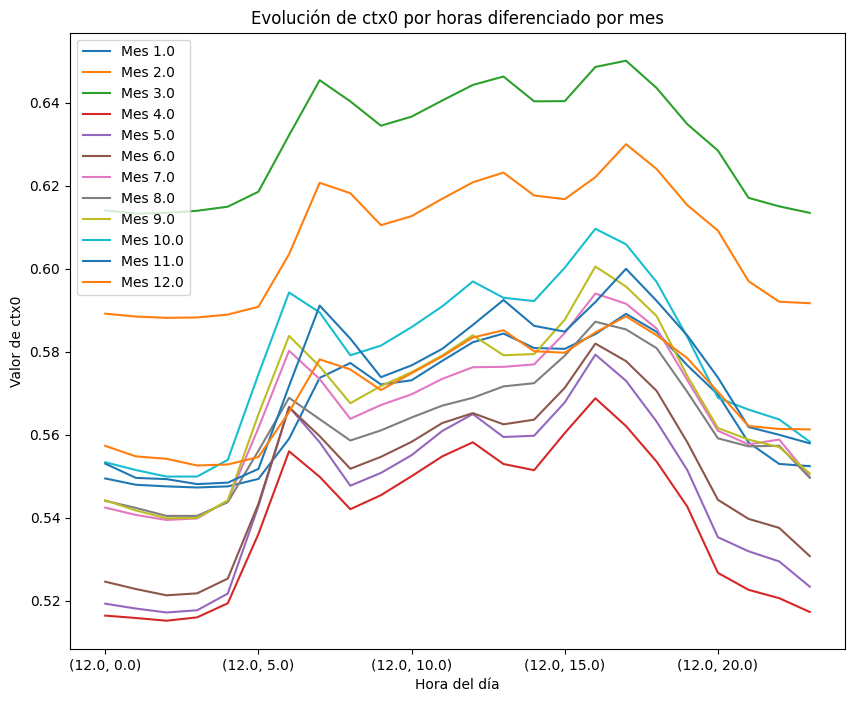

In [66]:
# Iteración sobre los grupos para generar línea por mes
for month, group in mean_by_month_hour.groupby(level=0):
    group.plot(label=f"Mes {month}")

# Ejes y leyenda
plt.xlabel('Hora del día')
plt.ylabel('Valor de ctx0')
plt.title('Evolución de ctx0 por horas diferenciado por mes')

plt.legend()
plt.show()

In [67]:
# Datos por día semana y hora, y calcula la media de 'ctx0' en cada grupo
mean_by_dayofweek_hour = filtered_bbdd.groupby(['dayofweek', 'hour'])['ctx0'].mean().compute()
print(mean_by_dayofweek_hour)

dayofweek  hour
0.0        0.0     0.552007
           1.0     0.551028
           2.0     0.550613
           3.0     0.551269
           4.0     0.554622
                     ...   
6.0        19.0    0.569714
           20.0    0.562630
           21.0    0.559209
           22.0    0.558167
           23.0    0.554945
Name: ctx0, Length: 168, dtype: float64


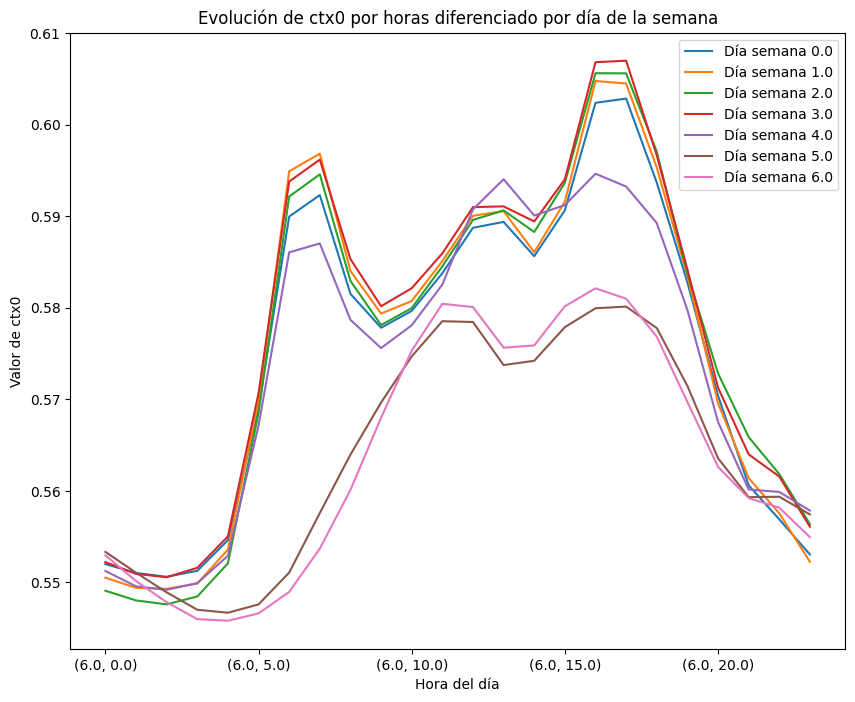

In [68]:
# Figura y eje
fig, ax = plt.subplots()

# Iteración sobre los grupos para generar línea por mes
for dayofweek, group in mean_by_dayofweek_hour.groupby(level=0):
    group.plot(ax=ax, label=f"Día semana {dayofweek}")

# Ejes y leyenda
ax.set_xlabel('Hora del día')
ax.set_ylabel('Valor de ctx0')
ax.set_title('Evolución de ctx0 por horas diferenciado por día de la semana')
ax.legend()

plt.show()

## Data Cleaning (DELETE)

# Datos adicionales
Tiempo, festivos Barcelona

## Festius 2019 - 2023 

In [69]:
client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

In [70]:
df_calendari_festius = pd.read_csv('./Altres_dades/calendari_festius.csv',sep=';')

In [72]:
df_calendari_festius['fecha'] = pd.to_datetime(df_calendari_festius['fecha'], format='%d/%m/%y')
df_calendari_festius.dtypes

fecha              datetime64[ns]
festius                    object
festius_sun                object
festius_sun_sat            object
dtype: object

In [73]:
df_calendari_festius['year'] = df_calendari_festius['fecha'].dt.year
df_calendari_festius['month'] = df_calendari_festius['fecha'].dt.month
df_calendari_festius['day'] = df_calendari_festius['fecha'].dt.day

In [74]:
df_calendari_festius['dayofweek'] = df_calendari_festius['fecha'].dt.dayofweek

In [75]:
type(df_calendari_festius)

pandas.core.frame.DataFrame

In [76]:
df_calendari_festius.drop('fecha', axis=1, inplace=True)

In [77]:
# replace IN_SERVICE with 0 and CLOSED with 1 
df_calendari_festius['festius'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)

df_calendari_festius['festius_sun'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)

df_calendari_festius['festius_sun_sat'].replace(
    to_replace=['No', 'Yes'],                       
    value=[0, 1], inplace=True)


In [78]:
df_calendari_festius.loc[df_calendari_festius.dayofweek.isin([5,6]), 'festius_sun_sat'] = 1

df_calendari_festius.loc[df_calendari_festius.dayofweek.isin([6]), 'festius_sun'] = 1

In [79]:
df_calendari_festius['weekend'] = 0

df_calendari_festius.loc[df_calendari_festius.dayofweek.isin([5,6]), 'weekend'] = 1


In [80]:
df_calendari_festius[df_calendari_festius.festius.isin([1]) & df_calendari_festius.year.isin([2022])]

,festius,festius_sun,festius_sun_sat,year,month,day,dayofweek,weekend
1096,1,1,1,2022,1,1,5,1
1101,1,1,1,2022,1,6,3,0
1200,1,1,1,2022,4,15,4,0
1203,1,1,1,2022,4,18,0,0
1252,1,1,1,2022,6,6,0,0
1270,1,1,1,2022,6,24,4,0
1322,1,1,1,2022,8,15,0,0
1362,1,1,1,2022,9,24,5,1
1364,1,1,1,2022,9,26,0,0
1380,1,1,1,2022,10,12,2,0


In [81]:
df_calendari_festius.drop('dayofweek', axis=1, inplace=True)

### Merge with data festius

In [82]:
# Realizar el merge utilizando Dask
#df_merged = dd.merge(bbdd_completa, df_calendari_festius[['fecha', 'festius', 'festius_sun', 'festius_sun_sat']], on='fecha', how='left')
bbdd_completa_festius = dd.merge(bbdd_completa, df_calendari_festius, on=['year', 'month', 'day'], how='left')


### Test correlations 

In [83]:
## correlacion
bbdd_completa_festius_20_22 = bbdd_completa_festius[bbdd_completa_festius.year.isin([2019, 2020, 2021, 2022])]


In [84]:
bbdd_completa_festius_20_22['festius'].corr(bbdd_completa_festius_20_22['ctx0']).compute()
# -0.017634788459456464

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


-0.01775467830095852

In [85]:
bbdd_completa_festius_20_22['festius_sun'].corr(bbdd_completa_festius_20_22['ctx0']).compute()
# -0.015361961250141202

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


-0.015745132149016714

In [86]:
bbdd_completa_festius_20_22['festius_sun_sat'].corr(bbdd_completa_festius_20_22['ctx0']).compute()
# -0.010289481745406845

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


-0.010688312010451952

In [87]:
bbdd_completa_festius_20_22['weekend'].corr(bbdd_completa_festius_20_22['ctx0']).compute()
# -0.009059519452955694

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/dask/dataframe/multi.py:1289: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


-0.009581487868528462

In [88]:
bbdd_completa_festius_20_22 = None

## Meteo

In [90]:
client.run(trim_memory)

{'tcp://127.0.0.1:34297': 1,
 'tcp://127.0.0.1:40501': 1,
 'tcp://127.0.0.1:43711': 1,
 'tcp://127.0.0.1:44285': 1,
 'tcp://127.0.0.1:44901': 1}

2022 - 2023

In [91]:
df_meteo_metadata = pd.read_csv('./Altres_dades/MetadataMeteo/MeteoCat_Metadades.csv',sep=',')

In [92]:
df_meteo_metadata

,CODI_VARIABLE,NOM_VARIABLE,UNITAT,ACRÒNIM
0,1000,Temperatura mitjana diària,°C,TM
1,1001,Temperatura màxima diària + hora,°C,TX
2,1002,Temperatura mínima diària + hora,°C,TN
3,1100,Humitat relativa mitjana diària,%,HRM
4,1101,Humitat relativa màxima diària + data,%,HRX
5,1102,Humitat relativa mínima diària + data,%,HRN
6,1200,Pressió atmosfèrica mitjana diària,hPa,PM
7,1201,Pressió atmosfèrica màxima diària + hora,hPa,PX
8,1202,Pressió atmosfèrica mínima diària + hora,hPa,PN
9,1300,Precipitació acumulada diària,mm,PPT


In [93]:
df_estadistica_meteo_19_d5 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_d5_observatori_fabra.csv',sep=',')
df_estadistica_meteo_19_x2 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x2_barcelona_zoo.csv',sep=',')
df_estadistica_meteo_19_x4 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x4_barcelona_el_raval.csv',sep=',')
df_estadistica_meteo_19_x8 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2019_x8_barcelona_zona_universitaria.csv',sep=',')

In [94]:
def convert_columns(data):
    print(data.shape)
    
    data.rename(
        columns={
            'PPT24H':'PPT',
            'DVX10':'DVVX10',
            'RS24H':'RS24h',
            'HPA':'PM'
        },
        inplace=True
    )
    
    for acro in df_meteo_metadata['ACRÒNIM'].values:
        if acro not in data.columns.values:
            data[acro] = np.nan
    
    code = data.CODI_ESTACIO.unique().tolist().pop()
    
    data.drop('CODI_ESTACIO', axis=1, inplace=True)

    data = data.set_index('DATA_LECTURA')

    data.columns = [f'VALOR_{col}_{code}' for col in data.columns.values]

    data = data.reset_index()

    data['DATA_LECTURA'] = pd.to_datetime(data['DATA_LECTURA'], format='%d/%m/%Y')
#     data['year'] = data['DATA_LECTURA'].dt.year
    
    print(data.shape)
    
    return data

In [95]:
df_estadistica_meteo_19_d5 = convert_columns(df_estadistica_meteo_19_d5)

df_estadistica_meteo_19_x2 = convert_columns(df_estadistica_meteo_19_x2)

df_estadistica_meteo_19_x4 = convert_columns(df_estadistica_meteo_19_x4)

df_estadistica_meteo_19_x8 = convert_columns(df_estadistica_meteo_19_x8)

(8766, 13)
(8766, 16)


In [99]:
df_estadistica_meteo_19 = pd.merge(
    pd.merge(
        df_estadistica_meteo_19_d5, df_estadistica_meteo_19_x2, 
        on='DATA_LECTURA',
        how='outer',
    ),
    pd.merge(
        df_estadistica_meteo_19_x4, df_estadistica_meteo_19_x8, 
        on='DATA_LECTURA',
        how='outer',
    ), 
    on='DATA_LECTURA',
    how='outer',
)


In [100]:
df_estadistica_meteo_19['year'] = df_estadistica_meteo_19['DATA_LECTURA'].dt.year

df_estadistica_meteo_19 = df_estadistica_meteo_19[df_estadistica_meteo_19.year.isin([2019])]

In [102]:
df_estadistica_meteo_20 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2020_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_21 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2021_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_22 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2022_MeteoCat_Detall_Estacions.csv',sep=',')
df_estadistica_meteo_23 = pd.read_csv('./Altres_dades/EstadísticsEstacionsMeteo/2023_MeteoCat_Detall_Estacions.csv',sep=',')


In [103]:
%%time 

df_estadistica_meteo_20.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_20.shape)

df_estadistica_meteo_21.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_21.shape)

df_estadistica_meteo_22.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_22.shape)

df_estadistica_meteo_23.drop('DATA_EXTREM', axis=1, inplace=True)
print(df_estadistica_meteo_23.shape)

df_20_21_22_23 = pd.concat([df_estadistica_meteo_20, df_estadistica_meteo_21, df_estadistica_meteo_22, df_estadistica_meteo_23])
print(df_20_21_22_23.shape)
#change indexing 
df_20_21_22_23 = pd.DataFrame(df_20_21_22_23.set_index(['ACRÒNIM', 'DATA_LECTURA', 'CODI_ESTACIO']).unstack(['ACRÒNIM']))
df_20_21_22_23 = df_20_21_22_23.reindex()
df_20_21_22_23 = df_20_21_22_23.unstack()
df_20_21_22_23.columns = ['_'.join(col) for col in df_20_21_22_23.columns.values]
df_20_21_22_23 = df_20_21_22_23.reset_index()

df_20_21_22_23['DATA_LECTURA'] = pd.to_datetime(df_20_21_22_23['DATA_LECTURA'], format='%Y-%m-%d')
df_20_21_22_23['year'] = df_20_21_22_23['DATA_LECTURA'].dt.year

# checking duplicates 
print('is there duplicates: ', (df_20_21_22_23.groupby('DATA_LECTURA').count().reset_index().VALOR_DVM10_D5 > 1 ).any())

print(df_20_21_22_23.shape)

(18637, 4)
(18615, 4)
(18605, 4)
(8007, 4)
(63864, 4)
is there duplicates:  False
(1253, 62)
CPU times: user 58.5 ms, sys: 4.11 ms, total: 62.6 ms
Wall time: 56.3 ms


In [104]:
df_estadistica_meteo = pd.concat([df_estadistica_meteo_19, df_20_21_22_23])

In [105]:
df_estadistica_meteo

,DATA_LECTURA,VALOR_TM_D5,VALOR_TX_D5,VALOR_TN_D5,VALOR_HRM_D5,VALOR_PPT_D5,VALOR_PM_D5,VALOR_RS24h_D5,VALOR_VVM10_D5,VALOR_DVM10_D5,VALOR_VVX10_D5,VALOR_DVVX10_D5,VALOR_HRX_D5,VALOR_HRN_D5,VALOR_PX_D5,VALOR_PN_D5,VALOR_TM_X2,VALOR_TX_X2,VALOR_TN_X2,VALOR_HRM_X2,VALOR_HRX_X2,VALOR_HRN_X2,VALOR_PM_X2,VALOR_PX_X2,VALOR_PN_X2,VALOR_PPT_X2,VALOR_RS24h_X2,VALOR_VVM10_X2,VALOR_DVM10_X2,VALOR_VVX10_X2,VALOR_DVVX10_X2,VALOR_TM_X4,VALOR_TX_X4,VALOR_TN_X4,VALOR_HRM_X4,VALOR_PPT_X4,VALOR_PM_X4,VALOR_RS24h_X4,VALOR_VVM10_X4,VALOR_DVM10_X4,VALOR_VVX10_X4,VALOR_DVVX10_X4,VALOR_HRX_X4,VALOR_HRN_X4,VALOR_PX_X4,VALOR_PN_X4,VALOR_TM_X8,VALOR_TX_X8,VALOR_TN_X8,VALOR_HRM_X8,VALOR_PPT_X8,VALOR_PM_X8,VALOR_RS24h_X8,VALOR_VVM10_X8,VALOR_DVM10_X8,VALOR_VVX10_X8,VALOR_DVVX10_X8,VALOR_HRX_X8,VALOR_HRN_X8,VALOR_PX_X8,VALOR_PN_X8,year
8401,2019-01-01,10.5,14.4,7.8,73.0,0.0,979.6,5.4,3.8,339.0,15.8,315.0,NaN,NaN,NaN,NaN,9.9,15.4,4.9,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.3,16.0,8.4,66.0,0.0,1024.5,8.2,1.3,307.0,7.9,301.0,NaN,NaN,NaN,NaN,11.2,17.0,7.0,71.0,0.0,1019.0,7.4,1.4,311.0,9.0,303.0,NaN,NaN,NaN,NaN,2019
8402,2019-01-02,8.9,12.9,5.9,48.0,0.0,976.5,9.4,8.3,324.0,17.3,318.0,NaN,NaN,NaN,NaN,8.8,14.5,5.1,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.2,16.3,8.1,47.0,0.0,1021.4,9.2,1.0,280.0,6.3,309.0,NaN,NaN,NaN,NaN,9.5,15.3,5.7,52.0,0.0,1015.9,9.1,1.7,293.0,10.2,304.0,NaN,NaN,NaN,NaN,2019
8403,2019-01-03,8.3,12.6,4.9,59.0,0.0,979.0,9.1,4.0,279.0,9.9,313.0,NaN,NaN,NaN,NaN,7.6,13.0,4.1,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.3,13.7,7.5,53.0,0.0,1024.3,8.9,1.1,264.0,4.6,263.0,NaN,NaN,NaN,NaN,8.8,13.4,4.4,59.0,0.0,1018.7,8.8,1.3,277.0,6.0,306.0,NaN,NaN,NaN,NaN,2019
8404,2019-01-04,7.2,11.3,5.3,69.0,0.0,980.6,8.0,2.0,205.0,7.8,290.0,NaN,NaN,NaN,NaN,7.0,11.7,3.3,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,12.3,6.4,59.0,0.0,1026.1,7.9,0.9,94.0,4.8,80.0,NaN,NaN,NaN,NaN,7.0,12.6,2.6,70.0,0.0,1020.5,7.7,1.2,292.0,4.1,164.0,NaN,NaN,NaN,NaN,2019
8405,2019-01-05,9.1,15.2,3.2,47.0,0.0,978.6,9.3,10.0,326.0,17.0,317.0,NaN,NaN,NaN,NaN,8.5,15.3,4.4,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9,16.3,6.8,45.0,0.0,1023.6,9.2,2.0,282.0,7.5,267.0,NaN,NaN,NaN,NaN,9.4,14.1,5.4,50.0,0.0,1018.1,9.2,3.1,296.0,10.8,307.0,NaN,NaN,NaN,NaN,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,2023-06-02,18.9,24.7,15.4,80.0,0.0,966.5,24.3,2.0,202.0,7.1,157.0,100.0,56.0,967.5,965.2,20.1,24.1,16.9,79.0,93.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.8,23.2,18.2,74.0,0.0,1010.0,24.9,1.7,159.0,5.9,152.0,92.0,55.0,1011.0,1008.6,20.6,25.2,15.8,77.0,0.0,1004.4,23.5,1.5,207.0,6.1,174.0,99.0,54.0,1005.4,1003.0,2023
1249,2023-06-03,18.2,22.8,15.3,86.0,0.1,966.9,15.4,1.8,190.0,6.9,151.0,100.0,65.0,968.0,965.4,20.3,22.7,17.6,81.0,91.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.8,22.8,18.9,76.0,0.0,1010.5,18.2,1.6,149.0,6.6,174.0,91.0,59.0,1011.7,1009.0,20.5,25.3,16.9,78.0,0.0,1004.8,16.2,1.4,170.0,6.9,181.0,100.0,58.0,1006.1,1003.4,2023
1250,2023-06-04,19.1,25.7,16.2,82.0,0.0,967.8,21.6,1.8,184.0,7.0,167.0,100.0,51.0,969.0,966.6,20.5,24.5,17.9,81.0,91.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,23.9,18.9,76.0,0.0,1011.4,23.8,1.6,127.0,6.3,101.0,93.0,62.0,1012.6,1010.2,20.8,25.9,17.2,77.0,0.0,1005.7,22.5,1.4,176.0,6.3,132.0,99.0,51.0,1007.0,1004.6,2023
1251,2023-06-05,19.9,25.5,15.9,75.0,0.0,968.0,26.1,3.3,239.0,8.9,191.0,99.0,52.0,968.8,966.9,21.5,25.7,17.3,75.0,91.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,24.6,18.9,67.0,0.0,1011.5,28.6,1.8,193.0,7.7,155.0,80.0,56.0,1012.4,1010.0,21.8,26.5,16.7,70.0,0.0,1005.9,27.7,1.7,220.0,7.2,209.0,95.0,51.0,1006.8,1004.7,2023


In [106]:
df_estadistica_meteo['month'] = df_estadistica_meteo['DATA_LECTURA'].dt.month
df_estadistica_meteo['day'] = df_estadistica_meteo['DATA_LECTURA'].dt.day

In [112]:
df_estadistica_meteo.drop('DATA_LECTURA', axis=1, inplace=True)

### Merge with data meteo

In [113]:
# Realizar el merge utilizando Dask
#df_merged = dd.merge(bbdd_completa, df_calendari_festius[['fecha', 'festius', 'festius_sun', 'festius_sun_sat']], on='fecha', how='left')
bbdd_completa_meteo = dd.merge(bbdd_completa, df_estadistica_meteo, on=['year', 'month', 'day'], how='left')


In [114]:
bbdd_completa_meteo

,station_id,num_docks_available,num_bikes_available,status,timestamp,is_renting,is_returning,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,year,month,dayofweek,day,dayofyear,hour,capacity,ctx0,ctx1,ctx2,ctx3,ctx4,VALOR_TM_D5,VALOR_TX_D5,VALOR_TN_D5,VALOR_HRM_D5,VALOR_PPT_D5,VALOR_PM_D5,VALOR_RS24h_D5,VALOR_VVM10_D5,VALOR_DVM10_D5,VALOR_VVX10_D5,VALOR_DVVX10_D5,VALOR_HRX_D5,VALOR_HRN_D5,VALOR_PX_D5,VALOR_PN_D5,VALOR_TM_X2,VALOR_TX_X2,VALOR_TN_X2,VALOR_HRM_X2,VALOR_HRX_X2,VALOR_HRN_X2,VALOR_PM_X2,VALOR_PX_X2,VALOR_PN_X2,VALOR_PPT_X2,VALOR_RS24h_X2,VALOR_VVM10_X2,VALOR_DVM10_X2,VALOR_VVX10_X2,VALOR_DVVX10_X2,VALOR_TM_X4,VALOR_TX_X4,VALOR_TN_X4,VALOR_HRM_X4,VALOR_PPT_X4,VALOR_PM_X4,VALOR_RS24h_X4,VALOR_VVM10_X4,VALOR_DVM10_X4,VALOR_VVX10_X4,VALOR_DVVX10_X4,VALOR_HRX_X4,VALOR_HRN_X4,VALOR_PX_X4,VALOR_PN_X4,VALOR_TM_X8,VALOR_TX_X8,VALOR_TN_X8,VALOR_HRM_X8,VALOR_PPT_X8,VALOR_PM_X8,VALOR_RS24h_X8,VALOR_VVM10_X8,VALOR_DVM10_X8,VALOR_VVX10_X8,VALOR_DVVX10_X8,VALOR_HRX_X8,VALOR_HRN_X8,VALOR_PX_X8,VALOR_PN_X8
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
